In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO

In [2]:
# ----------------------------------------------------------------------------------------------------#
# - Bring in public data -
# ----------------------------------------------------------------------------------------------------#

# Try and access file path of public data 
url = 'https://github.com/cshuler/VOC_Processing_Maui/blob/main/MASTER_Maui_VOC_Sheet_PUBLIC.csv?raw=true'
df = pd.read_csv(url,index_col=0)
print(df.head(5))
# Only have tapwater samples 
tap_water_variations = ['Tap Water', 'tap', 'Tap', 'tap water']
#Filter the dataframe
tapwaterdf = df[df['SampleType'].isin(tap_water_variations)]
print(tapwaterdf)

# ----------------------------------------------------------------------------------------------------#
# - Bring in clean VOC data -
# ----------------------------------------------------------------------------------------------------#

# Function to get the list of CSV files from the GitHub repository page
def get_csv_files_from_repo(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        files = response.json()
        csv_files = [file['download_url'] for file in files if file['name'].endswith('.csv')]
        return csv_files
    else:
        raise ValueError(f"Failed to fetch repository contents: {response.status_code}")

# URL of the GitHub repository API
api_url = "https://api.github.com/repos/cshuler/VOC_Processing_Maui/contents/Clean_Data"

# Get the list of CSV files
csv_files = get_csv_files_from_repo(api_url)

# Check if the list of CSV files is populated
if not csv_files:
    raise ValueError("No CSV files found in the repository")

# Function to read a CSV file from a URL into a DataFrame
def read_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    return pd.read_csv(StringIO(response.text))

# Read all CSV files into a list of DataFrames and set 'Peak' as the index
dataframes = []
for url in csv_files:
    try:
        df = read_csv_from_url(url)
        df.set_index('Peak', inplace=True)
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {url}: {e}")
# Ensure there are DataFrames to concatenate
if not dataframes:
    raise ValueError("No DataFrames were read successfully")

     Sample ID          SampleType   DateTime Taken Post Results    Public X  \
0  08-16-CKS-1           DI water    8/16/2023 8:15            N -156.475427   
1  08-16-CKS-2           Tap Water   8/16/2023 9:30          NaN -156.314808   
2  08-16-CKS-3           Tap Water  8/16/2023 10:52          NaN -156.307080   
3  08-16-CKS-4           Tap Water  8/16/2023 11:11          NaN -156.310102   
4  08-16-CKS-5  Tap Water Filtered  8/16/2023 11:30          NaN -156.307506   

    Public Y  
0  20.888238  
1  20.775476  
2  20.776551  
3  20.775450  
4  20.779323  
        Sample ID SampleType   DateTime Taken Post Results    Public X  \
1     08-16-CKS-2  Tap Water   8/16/2023 9:30          NaN -156.314808   
2     08-16-CKS-3  Tap Water  8/16/2023 10:52          NaN -156.307080   
3     08-16-CKS-4  Tap Water  8/16/2023 11:11          NaN -156.310102   
5     08-16-CKS-6  Tap Water  8/16/2023 12:00          NaN -156.310614   
6     08-16-CKS-7  Tap Water  8/16/2023 12:22          NaN 

In [3]:
# ----------------------------------------------------------------------------------------------------#
# - Calc detects -
# ----------------------------------------------------------------------------------------------------#

def compare_samples_to_limit(df):
    # Identify the reporting limit column
    limit_col = [col for col in df.columns if 'Reporting_Limit' in col][0]
    
    # Identify the sample columns (all columns except the reporting limit)
    sample_cols = [col for col in df.columns if col != limit_col]
    
    # Compare and set sample values
    for sample_col in sample_cols:
        df[sample_col] = df.apply(lambda row: 0 if row[sample_col] < row[limit_col] else row[sample_col], axis=1)
    
    return df

# Process each DataFrame
for i, df in enumerate(dataframes):
    df.replace(['n.a.', 'n.a./n.r.'], np.nan, inplace=True)
    # Convert all values to numeric (float), coercing errors to NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    dataframes[i] = compare_samples_to_limit(df) 
    
# Note that # ALL VALUES LESS THAN REPORTING LIMIT IS SET TO 0#

In [10]:
# ----------------------------------------------------------------------------------------------------#
# - Combine both datasets -
# ----------------------------------------------------------------------------------------------------#

# Combine all DataFrames into one using an outer join to align the chemicals
combined_df = pd.concat(dataframes, axis=1, join='outer')

# Display the combined DataFrame
print("Combined DataFrame:")


specified_chemicals = ["Chloromethane (methyl chloride)", "Chloroethene (vinyl chloride)", 
    "Bromomethane (methyl bromide)", "Chloroethane (ethyl chloride)",
    "Trichlorofluoromethane", "Diethyl ether", "1,1-Dichloroethene", "Acetone",
    "Iodomethane", "Carbon disulfide", "3-Chloropropene (allyl chloride)",
    "Methylene chloride (DCM)", "trans-1,2-Dichloroethene", "Methyl tert-butyl ether (MTBE)",
    "1,1-Dichloroethane", "2,2-Dichloropropane", "cis-1,2-Dichloroethene", "2-Butanone (MEK)",
    "Methyl acrylate", "Methacrylonitrile", "Bromochloromethane", "Tetrahydrofuran",
    "Trichloromethane (chloroform)", "1,1,1-Trichloroethane", "Dibromofluoromethane [SS1]",
    "Pentafluorobenzene [IS1]", "1-Chlorobutane (butyl chloride)", "Carbon tetrachloride",
    "1,1-Dichloropropene", "Benzene", "1,2-Dichloroethane", "1,4-Difluorobenzene [IS2]",
    "Trichloroethene", "1,2-Dichloropropane", "Dibromomethane", "Methyl methacrylate",
    "Bromodichloromethane", "2-Nitropropane", "cis-1,3-Dichloropropene", "4-Methyl-2-pentanone (MIBK)",
    "Toluene-d8 [SS2]", "Toluene", "trans-1,3-Dichloropropene", "Ethyl methacrylate",
    "1,1,2-Trichloroethane", "Tetrachloroethene", "1,3-Dichloropropane", "2-Hexanone",
    "Dibromochloromethane", "1,2-Dibromoethane (EDB)", "Chlorobenzene-d5 [IS3]", "Chlorobenzene",
    "1,1,1,2-Tetrachloroethane", "Ethylbenzene", "m/p-Xylene", "o-Xylene", "Styrene",
    "Bromoform", "Isopropylbenzene (cumene)", "1-Bromo-4-fluorobenzene (BFB) [SS3]",
    "Bromobenzene", "1,1,2,2-Tetrachloroethane", "1,2,3-Trichloropropane (TCP)",
    "trans-1,4-Dichloro-2-butene", "n-Propylbenzene", "2-Chlorotoluene", "1,3,5-Trimethylbenzene",
    "4-Chlorotoluene", "tert-Butylbenzene", "Pentachloroethane", "1,2,4-Trimethylbenzene",
    "1-Methylpropylbenzene (sec-butylbenzene)", "1,3-Dichlorobenzene", "4-Isopropyltoluene (p-cymene)",
    "1,4-Dichlorobenzene-d4 [IS4]", "1,4-Dichlorobenzene", "n-Butylbenzene", "1,2-Dichlorobenzene",
    "Hexachloroethane", "1,2-Dibromo-3-chloropropane (DBCP)", "Nitrobenzene", "1,2,4-Trichlorobenzene",
    "Hexachloro-1,3-butadiene", "Naphthalene", "1,2,3-Trichlorobenzene"
]

combined_df.head()

Combined DataFrame:


Reporting_Limit  HolmesTap  08-16-CKS-1  \
Peak                                                                       
Chloromethane (methyl chloride)              2.0        NaN          NaN   
Chloroethene (vinyl chloride)                2.0        NaN          NaN   
Bromomethane (methyl bromide)                2.0        0.0          0.0   
Chloroethane (ethyl chloride)                2.0        NaN          0.0   
Trichlorofluoromethane                       2.0        0.0          0.0   

                                 08-16-CKS-2  08-16-CKS-7  08-16-CKS-8  \
Peak                                                                     
Chloromethane (methyl chloride)          NaN          NaN          NaN   
Chloroethene (vinyl chloride)            NaN          NaN          NaN   
Bromomethane (methyl bromide)            0.0          NaN          0.0   
Chloroethane (ethyl chloride)            NaN          0.0          NaN   
Trichlorofluoromethane                   NaN          NaN          NaN   

                                 08-16-CKS-10  08-16-CKS-12  Reporting_Limit  \
Peak                                                                           
Chloromethane (methyl chloride)           NaN           NaN              2.0   
Chloroethene (vinyl chloride)             NaN           NaN              2.0   
Bromomethane (methyl bromide)             0.0           0.0              2.0   
Chloroethane (ethyl chloride)             0.0           NaN              2.0   
Trichlorofluoromethane                    NaN           NaN              2.0   

                                 DIH2O-Vial  ...  06-14-KDP-18  06-14-KDP-19  \
Peak                                         ...                               
Chloromethane (methyl chloride)         NaN  ...           NaN           NaN   
Chloroethene (vinyl chloride)           NaN  ...           NaN           NaN   
Bromomethane (methyl bromide)           0.0  ...           0.0           0.0   
Chloroethane (ethyl chloride)           NaN  ...           NaN           NaN   
Trichlorofluoromethane                  0.0  ...           NaN           NaN   

                                 06-14-KDP-20  Reporting_Limit  07-19-KDP-01  \
Peak                                                                           
Chloromethane (methyl chloride)           NaN              1.0           NaN   
Chloroethene (vinyl chloride)             NaN              1.0           NaN   
Bromomethane (methyl bromide)             0.0              1.0           0.0   
Chloroethane (ethyl chloride)             NaN              1.0           NaN   
Trichlorofluoromethane                    NaN              1.0           NaN   

                                 07-19-KDP-02  07-19-KDP-03  07-19-KDP-04  \
Peak                                                                        
Chloromethane (methyl chloride)           NaN           NaN           NaN   
Chloroethene (vinyl chloride)             NaN           NaN           NaN   
Bromomethane (methyl bromide)             0.0           0.0           0.0   
Chloroethane (ethyl chloride)             NaN           NaN           NaN   
Trichlorofluoromethane                    NaN           NaN           NaN   

                                 07-19-KDP-05  07-19-KDP-06  
Peak                                                         
Chloromethane (methyl chloride)           NaN           NaN  
Chloroethene (vinyl chloride)             NaN           NaN  
Bromomethane (methyl bromide)             0.0           0.0  
Chloroethane (ethyl chloride)             NaN           NaN  
Trichlorofluoromethane                    NaN           NaN  

[5 rows x 634 columns]

In [11]:
# ----------------------------------------------------------------------------------------------------#
# -DATFRAME comboination cleanup -
# ----------------------------------------------------------------------------------------------------#

filtered_combined_df = combined_df.loc[specified_chemicals]

# Transpose the filtered dataframe
transposed_df = filtered_combined_df.T

# Reset the index to turn columns into rows
transposed_df.reset_index(inplace=True)
transposed_df.rename(columns={'index': 'Sample ID'}, inplace=True)


merged_df = pd.merge(tapwaterdf, transposed_df, on='Sample ID', how='inner')

def is_in_bounding_box(lat, lon, bounding_box):
    lat_min, lon_min, lat_max, lon_max = bounding_box
    return lat_min <= lat <= lat_max and lon_min <= lon <= lon_max

def get_city(latitude, longitude):
    lahaina_bounding_box = (20.8485, -156.6967, 20.907, -156.6429)
    kula_bounding_box = (20.685866, -156.402346, 20.812532, -156.277054)

    if is_in_bounding_box(latitude, longitude, lahaina_bounding_box):
        return "Lahaina"
    elif is_in_bounding_box(latitude, longitude, kula_bounding_box):
        return "Kula"
    else:
        return "Outside of Boxes"

# Apply the get_city function to each row in the DataFrame
merged_df['City'] = merged_df.apply(lambda row: get_city(row['Public Y'], row['Public X']), axis=1)

In [22]:
merged_df.head()

Sample ID SampleType   DateTime Taken Post Results    Public X  \
0  08-16-CKS-2  Tap Water   8/16/2023 9:30          NaN -156.314808   
1  08-16-CKS-3  Tap Water  8/16/2023 10:52          NaN -156.307080   
2  08-16-CKS-4  Tap Water  8/16/2023 11:11          NaN -156.310102   
3  08-16-CKS-6  Tap Water  8/16/2023 12:00          NaN -156.310614   
4  08-16-CKS-7  Tap Water  8/16/2023 12:22          NaN -156.309847   

    Public Y  Chloromethane (methyl chloride)  Chloroethene (vinyl chloride)  \
0  20.775476                              NaN                            NaN   
1  20.776551                              NaN                            NaN   
2  20.775450                              NaN                            NaN   
3  20.774563                              0.0                            NaN   
4  20.776287                              NaN                            NaN   

   Bromomethane (methyl bromide)  Chloroethane (ethyl chloride)  ...  \
0                            0.0                            NaN  ...   
1                            0.0                            0.0  ...   
2                            0.0                            NaN  ...   
3                            0.0                            NaN  ...   
4                            NaN                            0.0  ...   

   1,2-Dichlorobenzene  Hexachloroethane  1,2-Dibromo-3-chloropropane (DBCP)  \
0                  0.0               NaN                                 NaN   
1                  0.0               NaN                                 NaN   
2                  0.0               NaN                                 NaN   
3                  0.0               NaN                                 NaN   
4                  0.0               NaN                                 NaN   

   Nitrobenzene  1,2,4-Trichlorobenzene  Hexachloro-1,3-butadiene  \
0           NaN                     0.0                       0.0   
1           NaN                     0.0                       0.0   
2           NaN                     0.0                       0.0   
3           NaN                     0.0                       0.0   
4           NaN                     0.0                       0.0   

   Naphthalene  1,2,3-Trichlorobenzene  City  Total Trihalomethanes  
0          0.0                     0.0  Kula                 22.259  
1          0.0                     0.0  Kula                 22.803  
2          0.0                     0.0  Kula                 21.652  
3          0.0                     0.0  Kula                 31.636  
4          0.0                     0.0  Kula                  2.209  

[5 rows x 93 columns]

In [13]:
# ----------------------------------------------------------------------------------------------------#
# - Creation of Lahaina+Kula DFs -
# ----------------------------------------------------------------------------------------------------#


lahaina_df = merged_df[merged_df['City'] == 'Lahaina']

def TTHM_Calculator(row):
    TTHM_List = ['Bromodichloromethane', 'Bromoform', 'Dibromochloromethane', 'Trichloromethane (chloroform)']
    empty_List = []
    
    for chemical in TTHM_List:
        value = row.get(chemical, np.nan)
        empty_List.append(value)
    
    TTHM = np.nansum(empty_List)  # Sum the list using nansum to treat NaNs as 0s
    return TTHM

# Apply the function to each row and create a new column 'TTHM'
lahaina_df['Total Trihalomethanes'] = lahaina_df.apply(TTHM_Calculator, axis=1)
non_chemical_columns = ['Sample ID', 'SampleType', 'DateTime Taken', 'Public X', 'Public Y', 'City', 'Post Results']
chemical_columns = [col for col in lahaina_df.columns if col not in non_chemical_columns]
plt.figure(figsize=(15, 8))


        
# plt.yscale('log')
# plt.title('Chemical Detections in Lahaina')
# plt.xlabel('Chemical')
# plt.ylabel('Concentration (log scale)')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


kula_df = merged_df[merged_df['City'] == 'Kula']
kula_df['Total Trihalomethanes'] = kula_df.apply(TTHM_Calculator, axis=1)
non_chemical_columns = ['Sample ID', 'SampleType', 'DateTime Taken', 'Public X', 'Public Y', 'City', 'Post Results']
chemical_columns = [col for col in kula_df.columns if col not in non_chemical_columns]
kula_df[chemical_columns] = kula_df[chemical_columns].apply(pd.to_numeric, errors='coerce')

# plt.figure(figsize=(15, 8))

# for chemical in chemical_columns:
#     concentrations = kula_df[chemical].dropna()
#     if not concentrations.empty:
#         plt.scatter([chemical] * len(concentrations), concentrations, marker='x', label=chemical)
# plt.yscale('log')
# plt.title('Chemical Detections in Kula')
# plt.xlabel('Chemical')
# plt.ylabel('Concentration (log scale)')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()


#TABLE
###columns:
    #Total number of samples
    #Number of detects
    # num of detects above health limit
    #chemical
    #gradient on chemical based on how many times it was above the health limit. MICROGRAMS/L
    

C:\Users\CS\AppData\Local\Temp\ipykernel_19900\1618806678.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lahaina_df['Total Trihalomethanes'] = lahaina_df.apply(TTHM_Calculator, axis=1)
C:\Users\CS\AppData\Local\Temp\ipykernel_19900\1618806678.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kula_df['Total Trihalomethanes'] = kula_df.apply(TTHM_Calculator, axis=1)
C:\Users\CS\AppData\Local\Temp\ipykernel_19900\1618806678.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

<Figure size 1080x576 with 0 Axes>

In [14]:
# ----------------------------------------------------------------------------------------------------#
# - Health limits -
# ----------------------------------------------------------------------------------------------------#

min_chronic_health_limit = {"Chloromethane (methyl chloride)": np.nan, 
                "Chloroethene (vinyl chloride)": 10, 
                "Bromomethane (methyl bromide)":10, 
                "Chloroethane (ethyl chloride)":np.nan,
                 "Trichlorofluoromethane":2000, 
                 "Diethyl ether":np.nan, 
                 "1,1-Dichloroethene":np.nan, 
                 "Acetone": 4000, 
                 "Carbon disulfide":700,
                "3-Chloropropene (allyl chloride)":30,
                "Methylene chloride (DCM)":5, 
                "trans-1,2-Dichloroethene": 9 ,
                "Methyl tert-butyl ether (MTBE)":700,
                "1,1-Dichloroethane": 80, 
                "2,2-Dichloropropane":np.nan, 
                "cis-1,2-Dichloroethene": 6 ,
                "2-Butanone (MEK)":4000,
                "Methyl acrylate":np.nan, 
                "Methacrylonitrile":np.nan, 
                "Bromochloromethane":np.nan, 
                "Tetrahydrofuran":600 ,
                "Trichloromethane (chloroform)": 20, 
                "1,1,1-Trichloroethane":5000,
                "Dibromofluoromethane [SS1]":np.nan,
                "Pentafluorobenzene [IS1]":np.nan, 
                "1-Chlorobutane (butyl chloride)":np.nan, 
                "Carbon tetrachloride":3,
                "1,1-Dichloropropene":np.nan, 
                "Benzene": 3 ,
                "1,2-Dichloroethane":60,
                "1,4-Difluorobenzene [IS2]":np.nan,
                "Trichloroethene":np.nan, 
                "1,2-Dichloropropane": 60,
                "Dibromomethane":np.nan, 
                "Methyl methacrylate":np.nan,
                "Bromodichloromethane":30, 
                "2-Nitropropane":np.nan, 
                "cis-1,3-Dichloropropene": np.nan, 
                "4-Methyl-2-pentanone (MIBK)":np.nan,
                "Toluene-d8 [SS2]":np.nan, 
                "Toluene":70, 
                "trans-1,3-Dichloropropene":np.nan, 
                "Ethyl methacrylate":np.nan,
                "1,1,2-Trichloroethane": 3,
                "Tetrachloroethene":np.nan, 
                "1,3-Dichloropropane":np.nan, 
                "2-Hexanone":np.nan,
                "Dibromochloromethane": 10,
                "1,2-Dibromoethane (EDB)":9, 
                "Chlorobenzene-d5 [IS3]":np.nan, 
                "Chlorobenzene":100,
                "1,1,1,2-Tetrachloroethane":70, 
                "Ethylbenzene":40,
                "m/p-Xylene":300, 
                "o-Xylene":300, 
                "Styrene":np.nan,
                "Bromoform": np.nan,
                "Isopropylbenzene (cumene)":300, 
                "1-Bromo-4-fluorobenzene (BFB) [SS3]":np.nan ,
                "Bromobenzene":np.nan, 
                "1,1,2,2-Tetrachloroethane":np.nan, 
                "1,2,3-Trichloropropane (TCP)": 7,
                "trans-1,4-Dichloro-2-butene":np.nan, 
                "n-Propylbenzene":np.nan, 
                "2-Chlorotoluene":np.nan, 
                "1,3,5-Trimethylbenzene":30, 
                "4-Chlorotoluene":np.nan, 
                "tert-Butylbenzene":np.nan, 
                "Pentachloroethane":np.nan, 
                "1,2,4-Trimethylbenzene":30,
                "1-Methylpropylbenzene (sec-butylbenzene)":np.nan, 
                "1,3-Dichlorobenzene":np.nan, 
                "4-Isopropyltoluene (p-cymene)":np.nan,
                "1,4-Dichlorobenzene-d4 [IS4]":np.nan, 
                "1,4-Dichlorobenzene": 50 ,
                "n-Butylbenzene":np.nan, 
                "1,2-Dichlorobenzene":600, 
                "Hexachloroethane":np.nan, 
                "1,2-Dibromo-3-chloropropane (DBCP)": np.nan,
                "Nitrobenzene":np.nan, 
                "1,2,4-Trichlorobenzene":100,#chronic
                "Hexachloro-1,3-butadiene":np.nan, 
                "Naphthalene":70 , 
                "1,2,3-Trichlorobenzene":np.nan,
}
chronic_df = pd.DataFrame(list(min_chronic_health_limit.items()), columns=['Chemical', 'MDPH Chronic'])

min_subchronic_limit = {
                 "Acetone": 5000, 
                "Methyl tert-butyl ether (MTBE)":700,
                "1,1-Dichloroethane": 400, 
                "cis-1,2-Dichloroethene": 20 ,
                "Tetrahydrofuran":600 ,
                "Trichloromethane (chloroform)": 20, 
                "1,1,1-Trichloroethane":20,
                "Carbon tetrachloride":3,
               
                "Benzene": 10 ,
                "1,2-Dichloroethane":200,
       
                "1,2-Dichloropropane": 20,
               
                "Bromodichloromethane":30, 
        
                "Toluene":70, 
                "1,2-Dibromoethane (EDB)":10, 
              
                "Ethylbenzene":40,
                "m/p-Xylene":300, 
                "o-Xylene":300, 
             
               
                "1,2,3-Trichloropropane (TCP)": 7,
               
                "1,3,5-Trimethylbenzene":30, 
                "1,2,4-Trimethylbenzene":30,
             
                "1,4-Dichlorobenzene": 50 ,
                "1,2-Dibromo-3-chloropropane (DBCP)": 0.2,
                
                "1,2,4-Trichlorobenzene":100,#chronic
                "Naphthalene":70 , 
}
subchronic_df = pd.DataFrame(list(min_subchronic_limit.items()), columns=['Chemical', 'MDPH Sub-Chronic'])
epa_mcgl_limit = {
    "Chloroethene (vinyl chloride)": 0,
    "trans-1,2-Dichloroethene": 100 ,
    "1,1-Dichloroethane": 0,
    "2,2-Dichloropropane":7,
    "cis-1,2-Dichloroethene": 7,
    "Trichloromethane (chloroform)": 70,
    "1,1,1-Trichloroethane":200,
    "Carbon tetrachloride":0,
    "Benzene": 0 ,
    "1,2-Dichloroethane":0,
    "1,2-Dichloropropane": 5,
    "Bromodichloromethane":0,
    "Toluene":1000, 
    "trans-1,3-Dichloropropene"
    "1,1,2-Trichloroethane": 3,
    "Dibromochloromethane": 60,
    "Chlorobenzene":100,
    "Ethylbenzene":700,
    "m/p-Xylene":1000, 
    "o-Xylene":1000, 
    "Styrene":100,
    "Bromoform": 0,
    "1,2-Dibromo-3-chloropropane (DBCP)": 0,
    "1,2,4-Trichlorobenzene":70,
    }
mcgl_df = pd.DataFrame(list(epa_mcgl_limit.items()), columns=['Chemical', 'EPA MCLG'])
epa_health_limits = {
    "Chloromethane (methyl chloride)": 5, 
    "Chloroethene (vinyl chloride)": 2,
    "1,1,1-Trichloroethane":200,
    "Carbon tetrachloride":5,
    "Benzene": 5 ,
    "1,2-Dichloroethane":5,
    "1,2-Dichloropropane": 5,
    "Toluene":1000, 
    "1,1,2-Trichloroethane": 5,
    "Chlorobenzene":100,
    "Ethylbenzene":700,
    "m/p-Xylene":1000, 
    "o-Xylene":1000, 
    "Styrene":100,
    "1,2-Dibromo-3-chloropropane (DBCP)": 0.2,
    "1,2,4-Trichlorobenzene":70,
    'Total Trihalomethanes': 80
    }
epa_limit_df = pd.DataFrame(list(epa_health_limits.items()), columns=['Chemical', 'EPA MCL'])

combined_limits_df = chronic_df.merge(subchronic_df, on='Chemical', how='outer').merge(mcgl_df, on='Chemical', how='outer').merge(epa_limit_df, on='Chemical', how='outer')


5.0
2.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
200.0
nan
nan
nan
5.0
nan
5.0
5.0
nan
nan
5.0
nan
nan
nan
nan
nan
nan
nan
1000.0
nan
nan
5.0
nan
nan
nan
nan
nan
nan
100.0
nan
700.0
1000.0
1000.0
100.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.2
nan
70.0
nan
nan
nan
80.0
5.0
2.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
200.0
nan
nan
nan
5.0
nan
5.0
5.0
nan
nan
5.0
nan
nan
nan
nan
nan
nan
nan
1000.0
nan
nan
5.0
nan
nan
nan
nan
nan
nan
100.0
nan
700.0
1000.0
1000.0
100.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.2
nan
70.0
nan
nan
nan
80.0


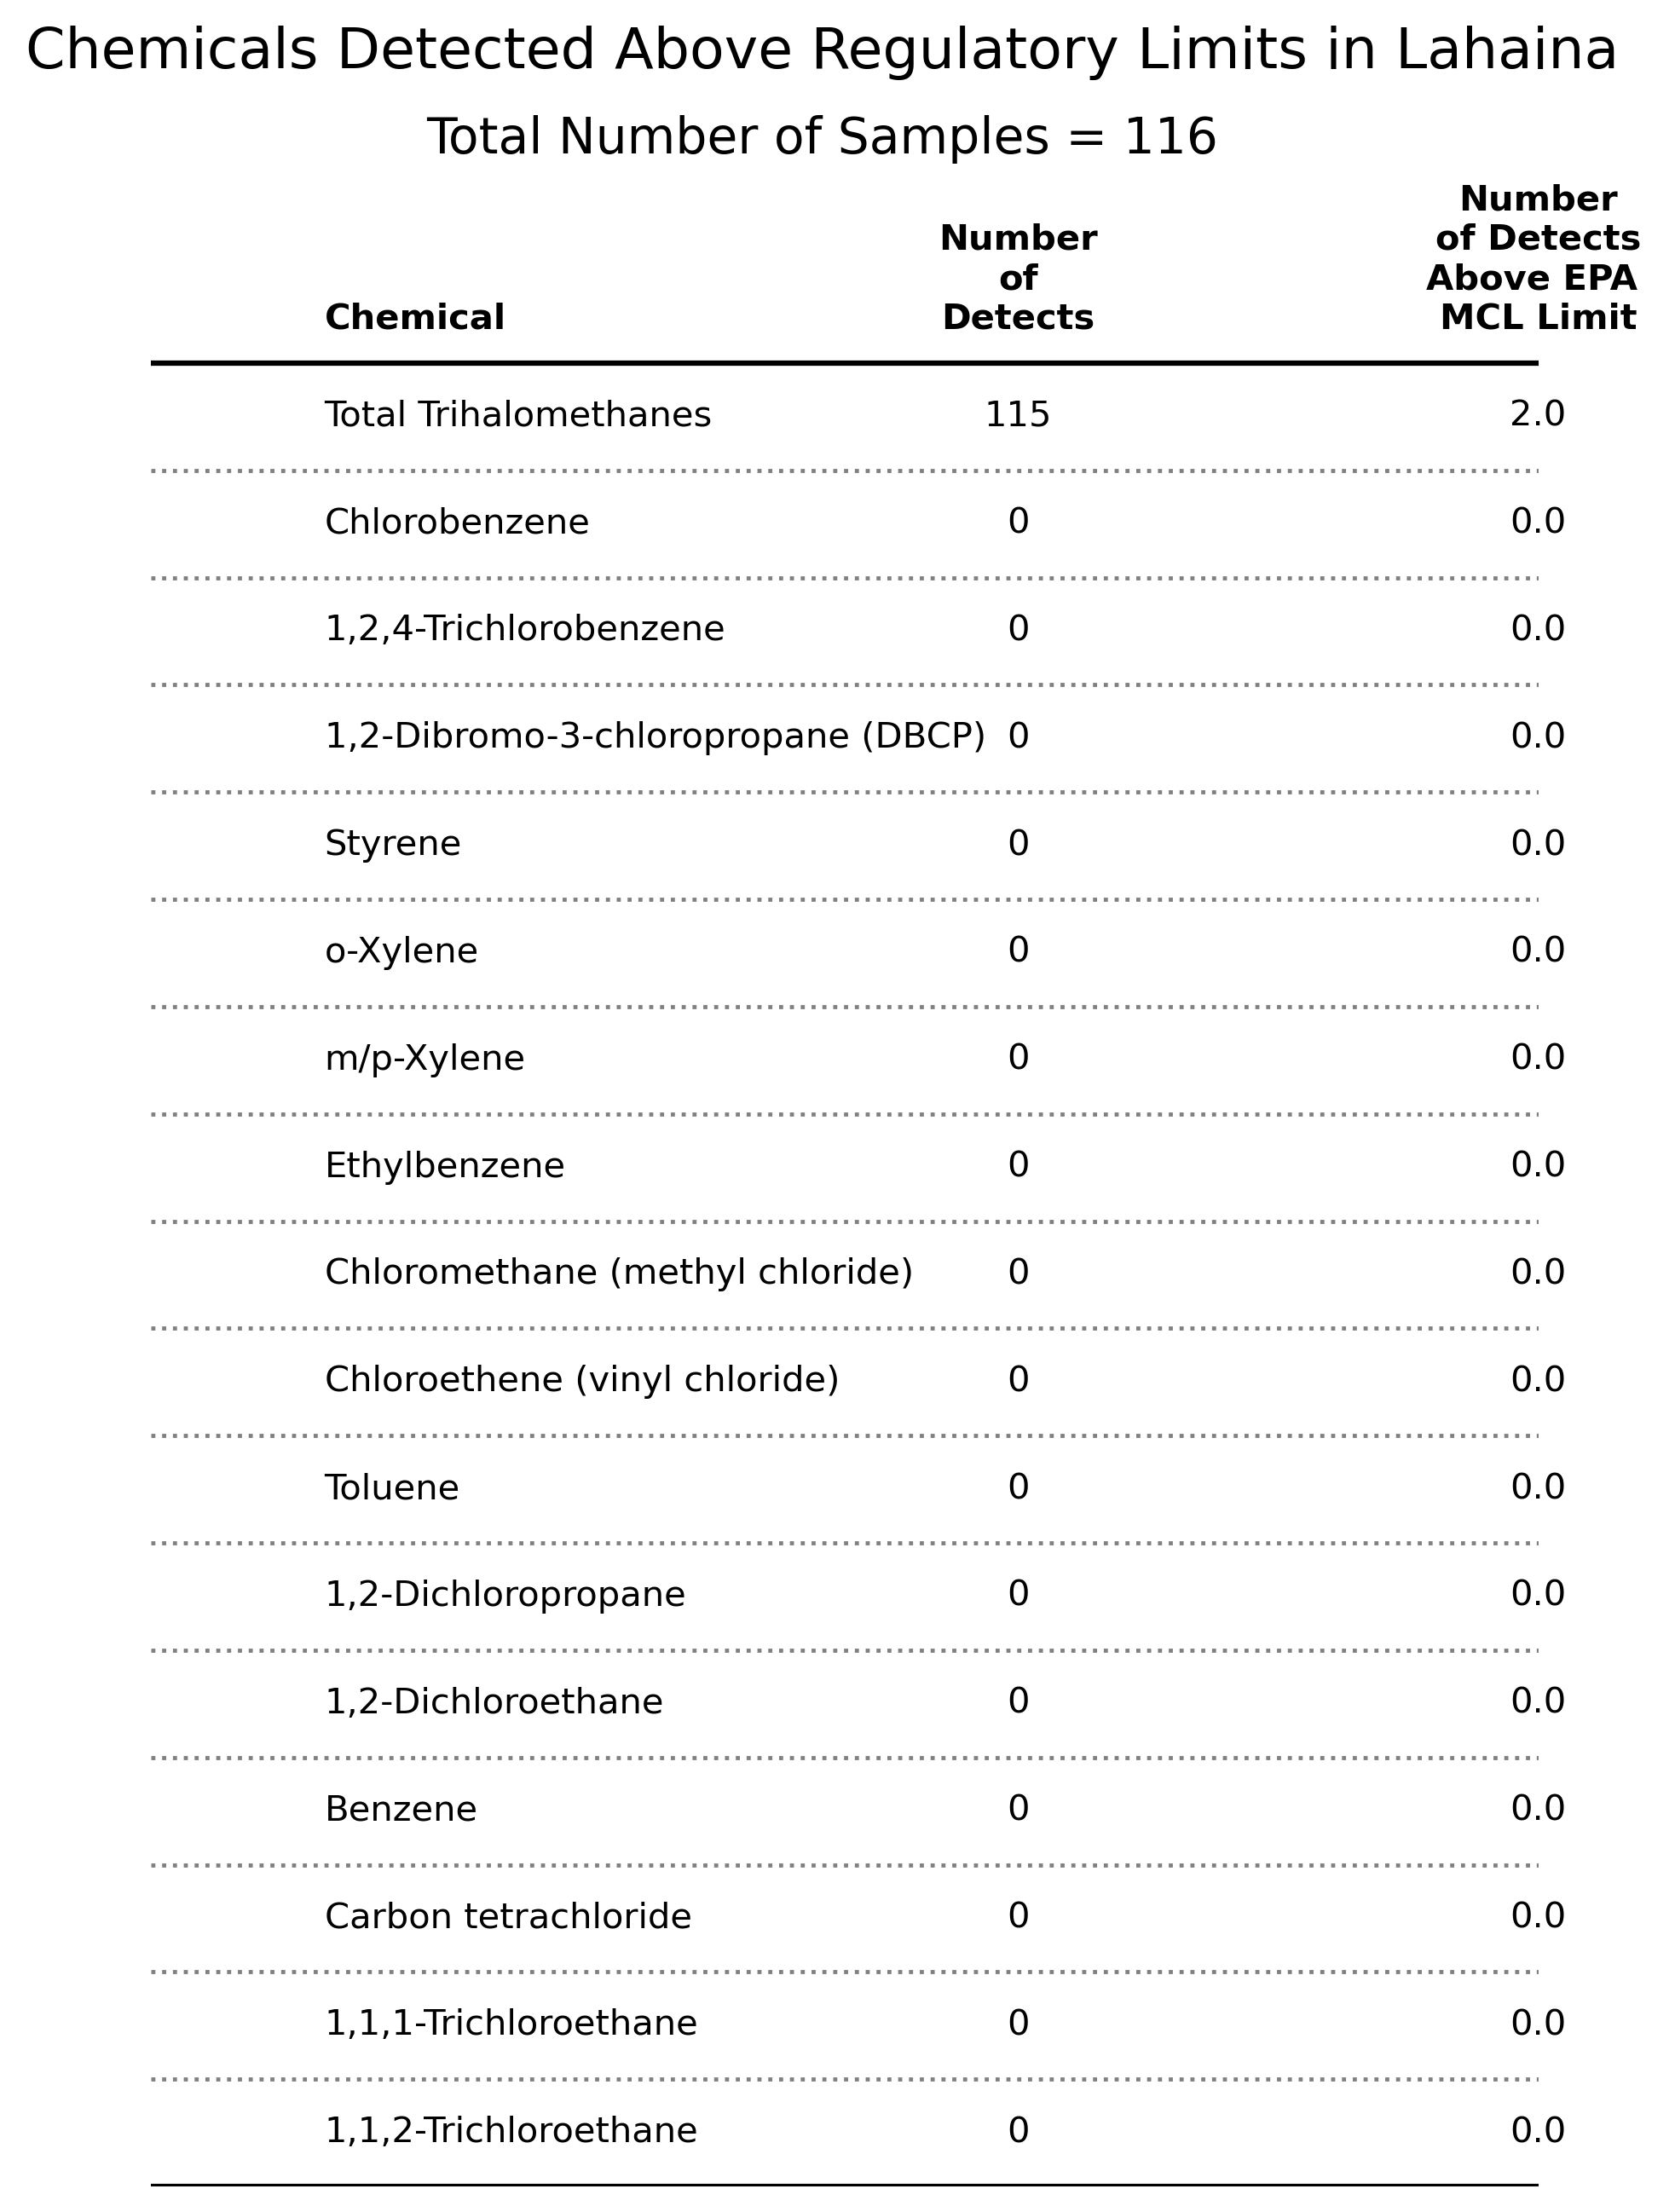

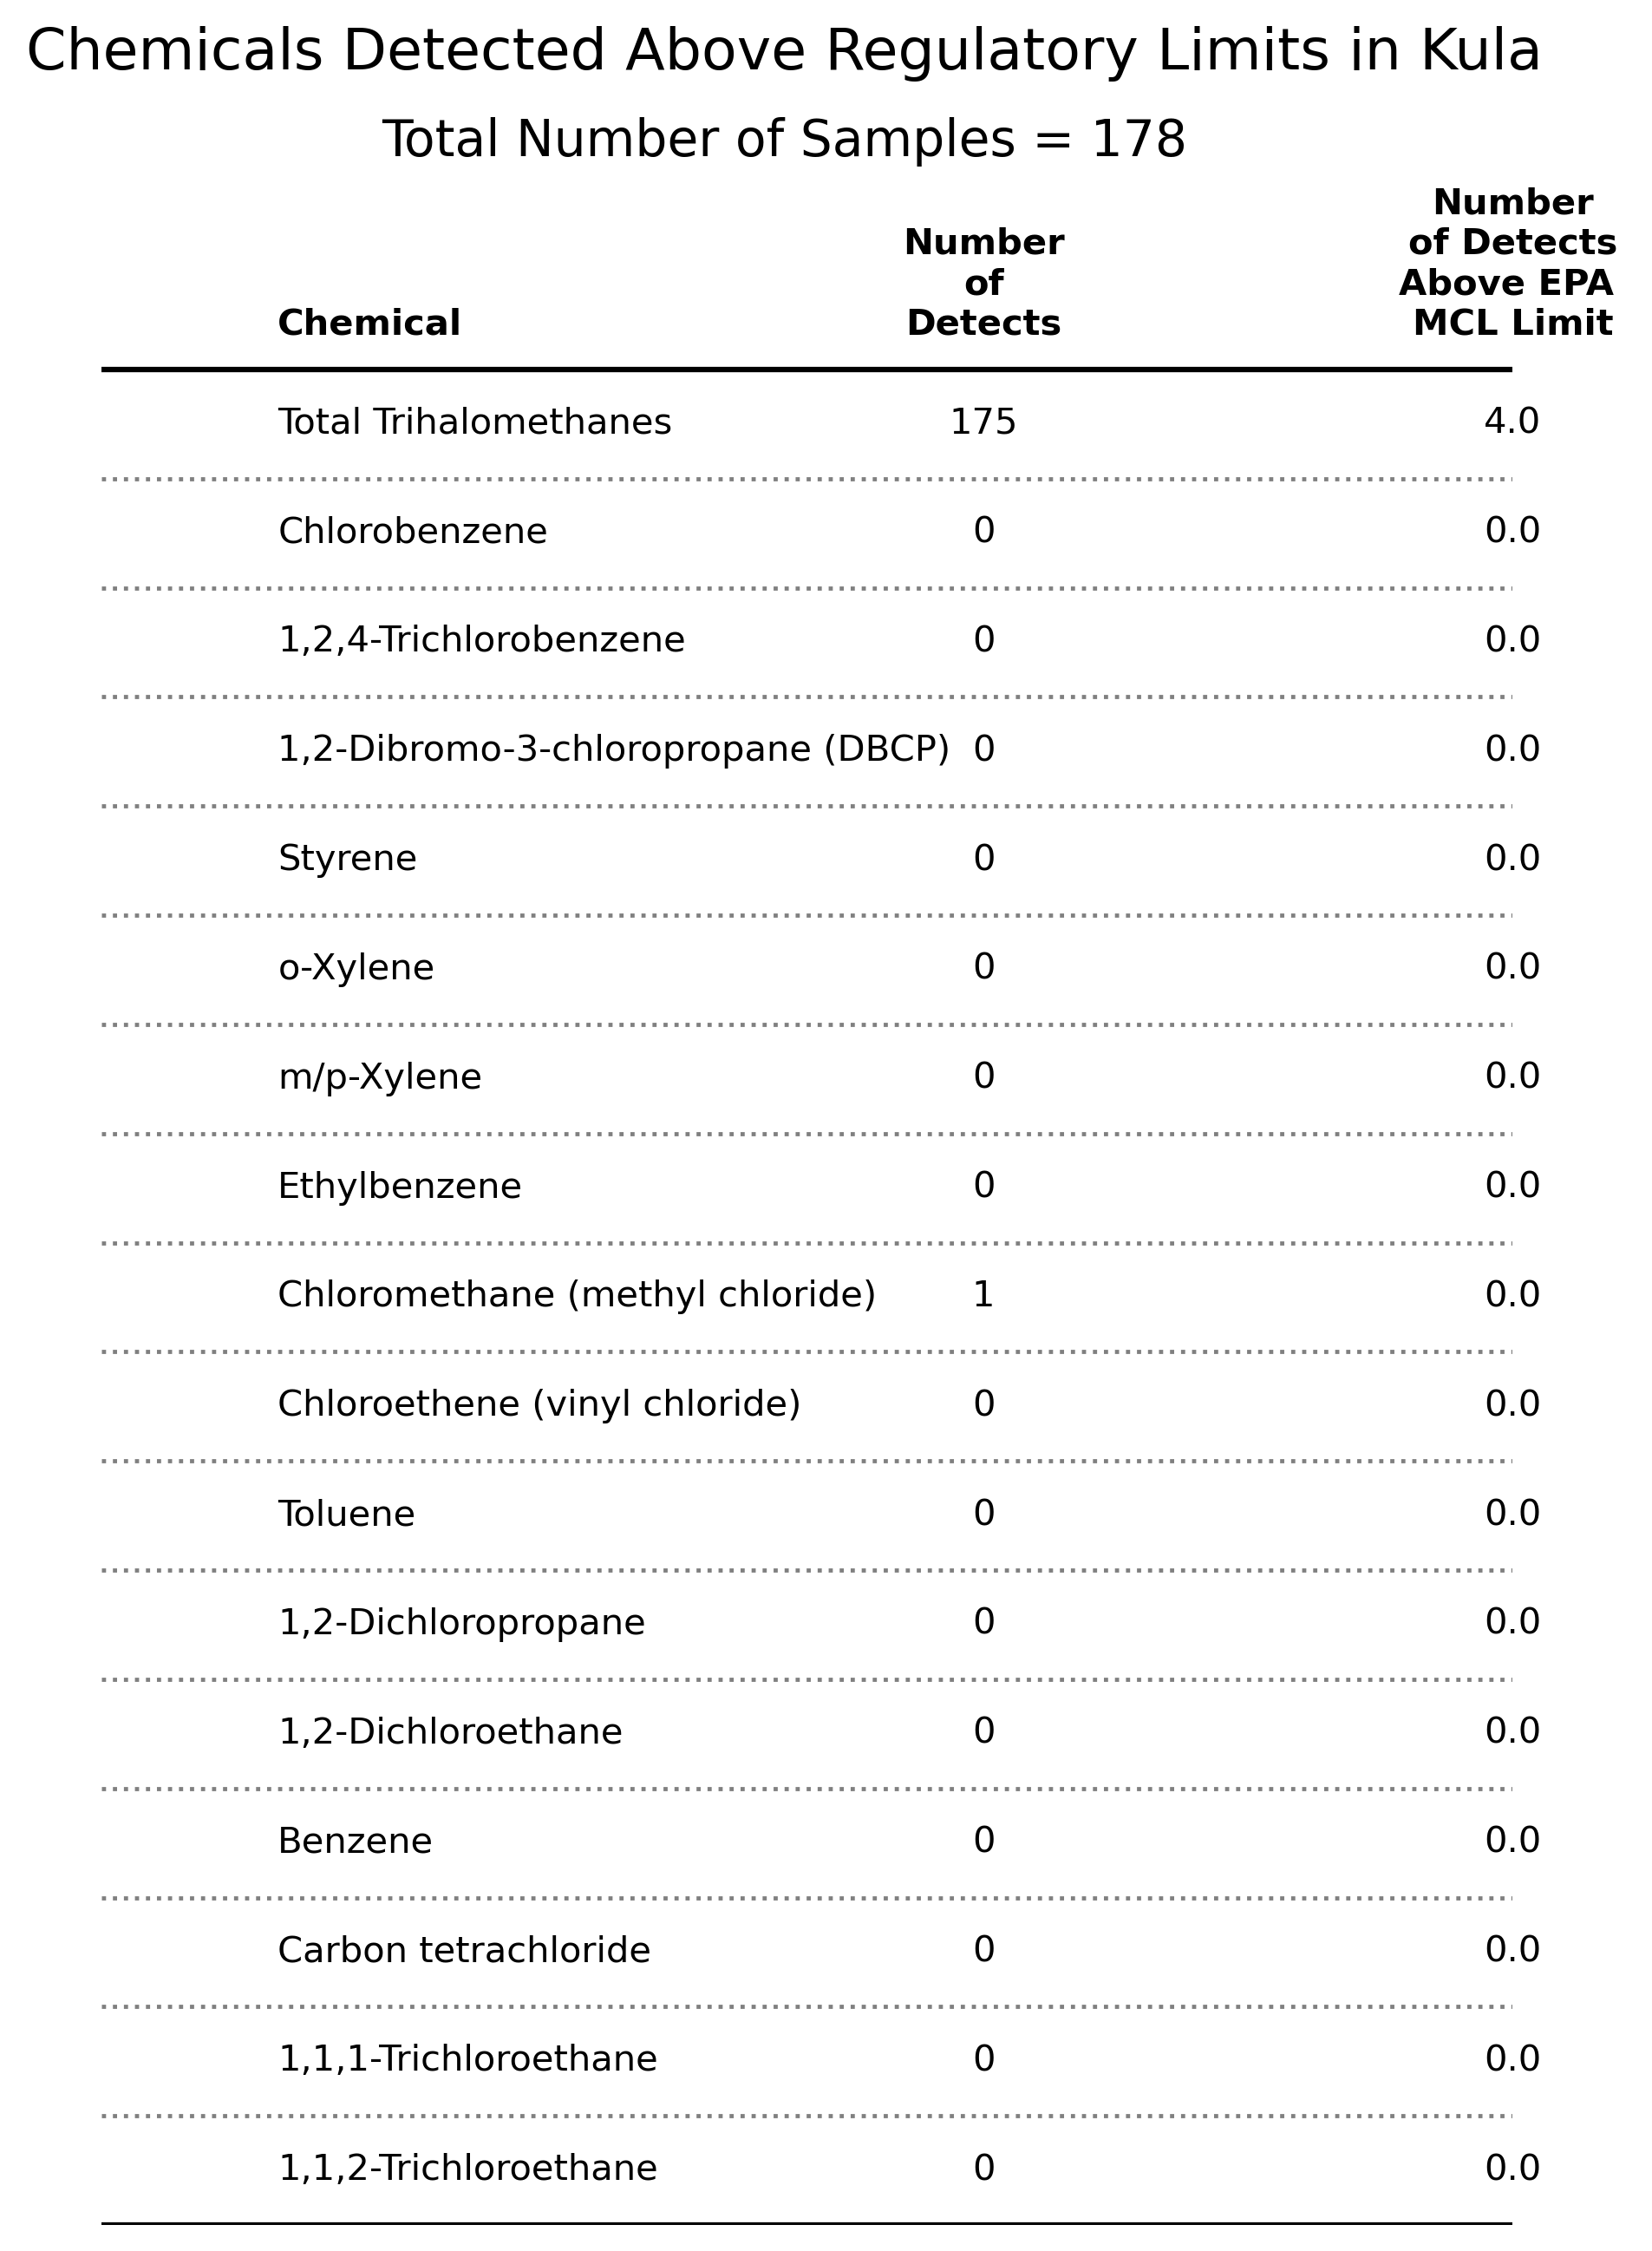

In [16]:
# ----------------------------------------------------------------------------------------------------#
# - Table for EPA MCL health limit statuses -
# ----------------------------------------------------------------------------------------------------#



summary_data_epa = []

#L A H A I N A

# Calculate the required columns for each chemical
for chemical in chemical_columns:
    total_samples_epa = lahaina_df.shape[0]
    
    # Count detects that are neither NaN nor 0
    number_of_detects_epa = lahaina_df[chemical].apply(lambda x: not pd.isna(x) and x != 0).sum()

    # Get the health limit for the current chemical
    limit_row_epa = epa_limit_df[epa_limit_df['Chemical'] == chemical]
    if not limit_row_epa.empty:
        limit_epa = limit_row_epa['EPA MCL'].values[0]
    else:
        limit_epa = np.nan
    print(limit_epa)

    if not np.isnan(limit_epa):
        number_of_detects_above_limit_epa = (lahaina_df[chemical] > limit_epa).sum()
    else:
        number_of_detects_above_limit_epa = np.nan

    summary_data_epa.append([chemical,number_of_detects_epa, number_of_detects_above_limit_epa])


# Convert summary data to a DataFrame
summary_df_epa = pd.DataFrame(summary_data_epa, columns=['Chemical', 'Number of Detects', 'Number of Detects Above EPA MCL Health Limit'])

# Filter out rows with NaN in 'Number of Detects Above EPA MCL Health Limit' and sort
filtered_summary_df_sorted = summary_df_epa.dropna(subset=['Number of Detects Above EPA MCL Health Limit']).sort_values(by='Number of Detects Above EPA MCL Health Limit', ascending=False)

# Plotting the table using matplotlib
fig = plt.figure(figsize=(7, 10), dpi=300)
ax = plt.subplot()

ncols = 3
nrows = filtered_summary_df_sorted.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.5, 2.5, 4]
columns = ['Chemical', 'Number of Detects', 'Number of Detects Above EPA MCL Health Limit']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        ha = 'left' if j == 0 else 'center'
        text_label = f'{filtered_summary_df_sorted[column].iloc[i]}'
        ax.annotate(
            xy=(positions[j], nrows - i - 0.5),
            text=text_label,
            ha=ha,
            va='center'
        )

# Add column names
column_names = ['Chemical', 'Number\nof\nDetects', 'Number\nof Detects\nAbove EPA \nMCL Limit']
for index, c in enumerate(column_names):
    ha = 'left' if index == 0 else 'center'
    ax.annotate(
        xy=(positions[index], nrows + 0.25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title above the table
plt.suptitle('Chemicals Detected Above Regulatory Limits in Lahaina', fontsize=16, y=.97)
# Add the line for total number of samples
total_samples = lahaina_df.shape[0]
plt.figtext(0.5, 0.92, f"Total Number of Samples = {total_samples}", ha='center', fontsize=14)
#plt.figtext(0.5, 0.92, '', ha='center', fontsize=14)
#plt.show()


#K U L A 
summary_data_epak = []
#Calculate the required columns for each chemical
for chemical in chemical_columns:
    total_samples_kula = kula_df.shape[0]
    
    # Count detects that are neither NaN nor 0
    number_of_detects_epak = kula_df[chemical].apply(lambda x: not pd.isna(x) and x != 0).sum()

    # Get the health limit for the current chemical
    limit_row_epak = epa_limit_df[epa_limit_df['Chemical'] == chemical]
    if not limit_row_epak.empty:
        limit_epak = limit_row_epak['EPA MCL'].values[0]
    else:
        limit_epak = np.nan
    print(limit_epak)

    if not np.isnan(limit_epak):
        number_of_detects_above_limit_epak = (kula_df[chemical] > limit_epak).sum()
    else:
        number_of_detects_above_limit_epak = np.nan

    summary_data_epak.append([chemical,number_of_detects_epak, number_of_detects_above_limit_epak])


# Convert summary data to a DataFrame
summary_df_epak = pd.DataFrame(summary_data_epak, columns=['Chemical', 'Number of Detects', 'Number of Detects Above EPA MCL Health Limit'])

# Filter out rows with NaN in 'Number of Detects Above EPA MCL Health Limit' and sort
filtered_summary_df_sortedk = summary_df_epak.dropna(subset=['Number of Detects Above EPA MCL Health Limit']).sort_values(by='Number of Detects Above EPA MCL Health Limit', ascending=False)

# Plotting the table using matplotlib
fig = plt.figure(figsize=(7, 10), dpi=300)
ax = plt.subplot()

ncols = 3
nrows = filtered_summary_df_sortedk.shape[0]

ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows + 1)

positions = [0.5, 2.5, 4]
columns = ['Chemical', 'Number of Detects', 'Number of Detects Above EPA MCL Health Limit']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        ha = 'left' if j == 0 else 'center'
        text_label = f'{filtered_summary_df_sortedk[column].iloc[i]}'
        ax.annotate(
            xy=(positions[j], nrows - i - 0.5),
            text=text_label,
            ha=ha,
            va='center'
        )

# Add column names
column_names = ['Chemical', 'Number\nof\nDetects', 'Number\nof Detects\nAbove EPA \nMCL Limit']
for index, c in enumerate(column_names):
    ha = 'left' if index == 0 else 'center'
    ax.annotate(
        xy=(positions[index], nrows + 0.25),
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3, marker='')

ax.set_axis_off()

# Add title above the table
plt.suptitle('Chemicals Detected Above Regulatory Limits in Kula', fontsize=16, y=.97)
# Add the line for total number of samples
total_samples_k = kula_df.shape[0]
plt.figtext(0.5, 0.92, f"Total Number of Samples = {total_samples_k}", ha='center', fontsize=14)
#plt.figtext(0.5, 0.92, '', ha='center', fontsize=14)

plt.show()


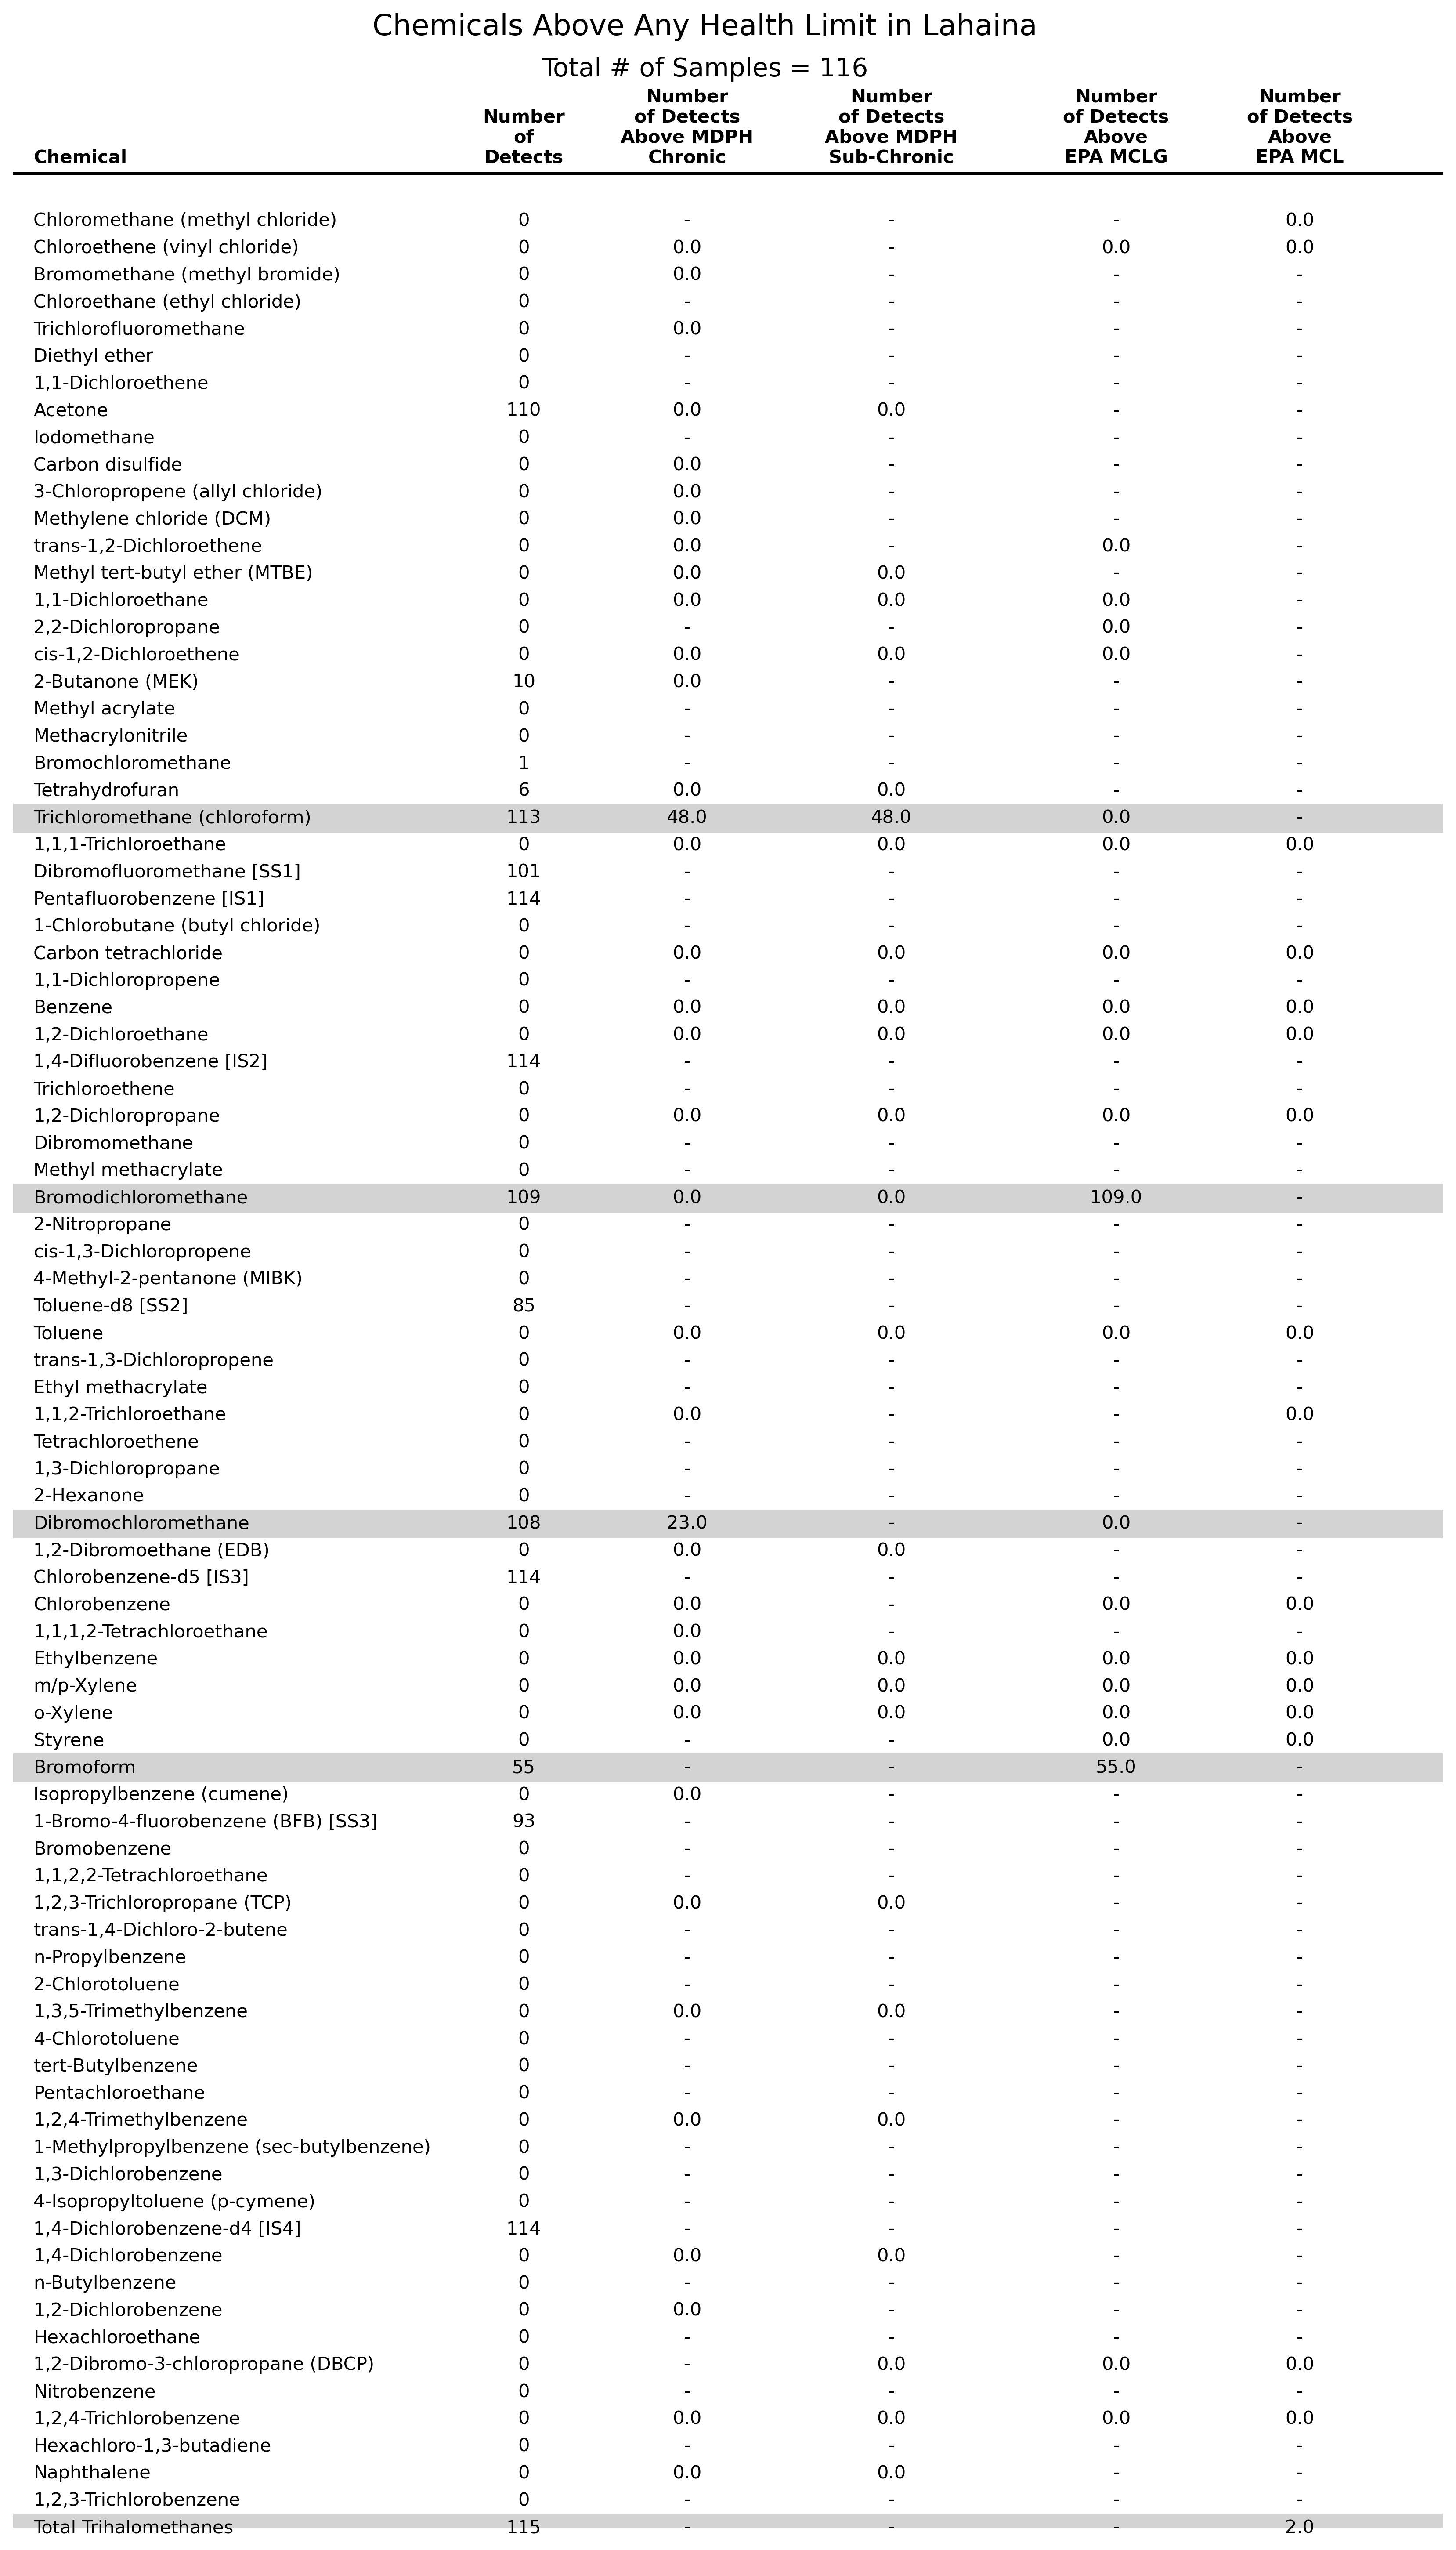

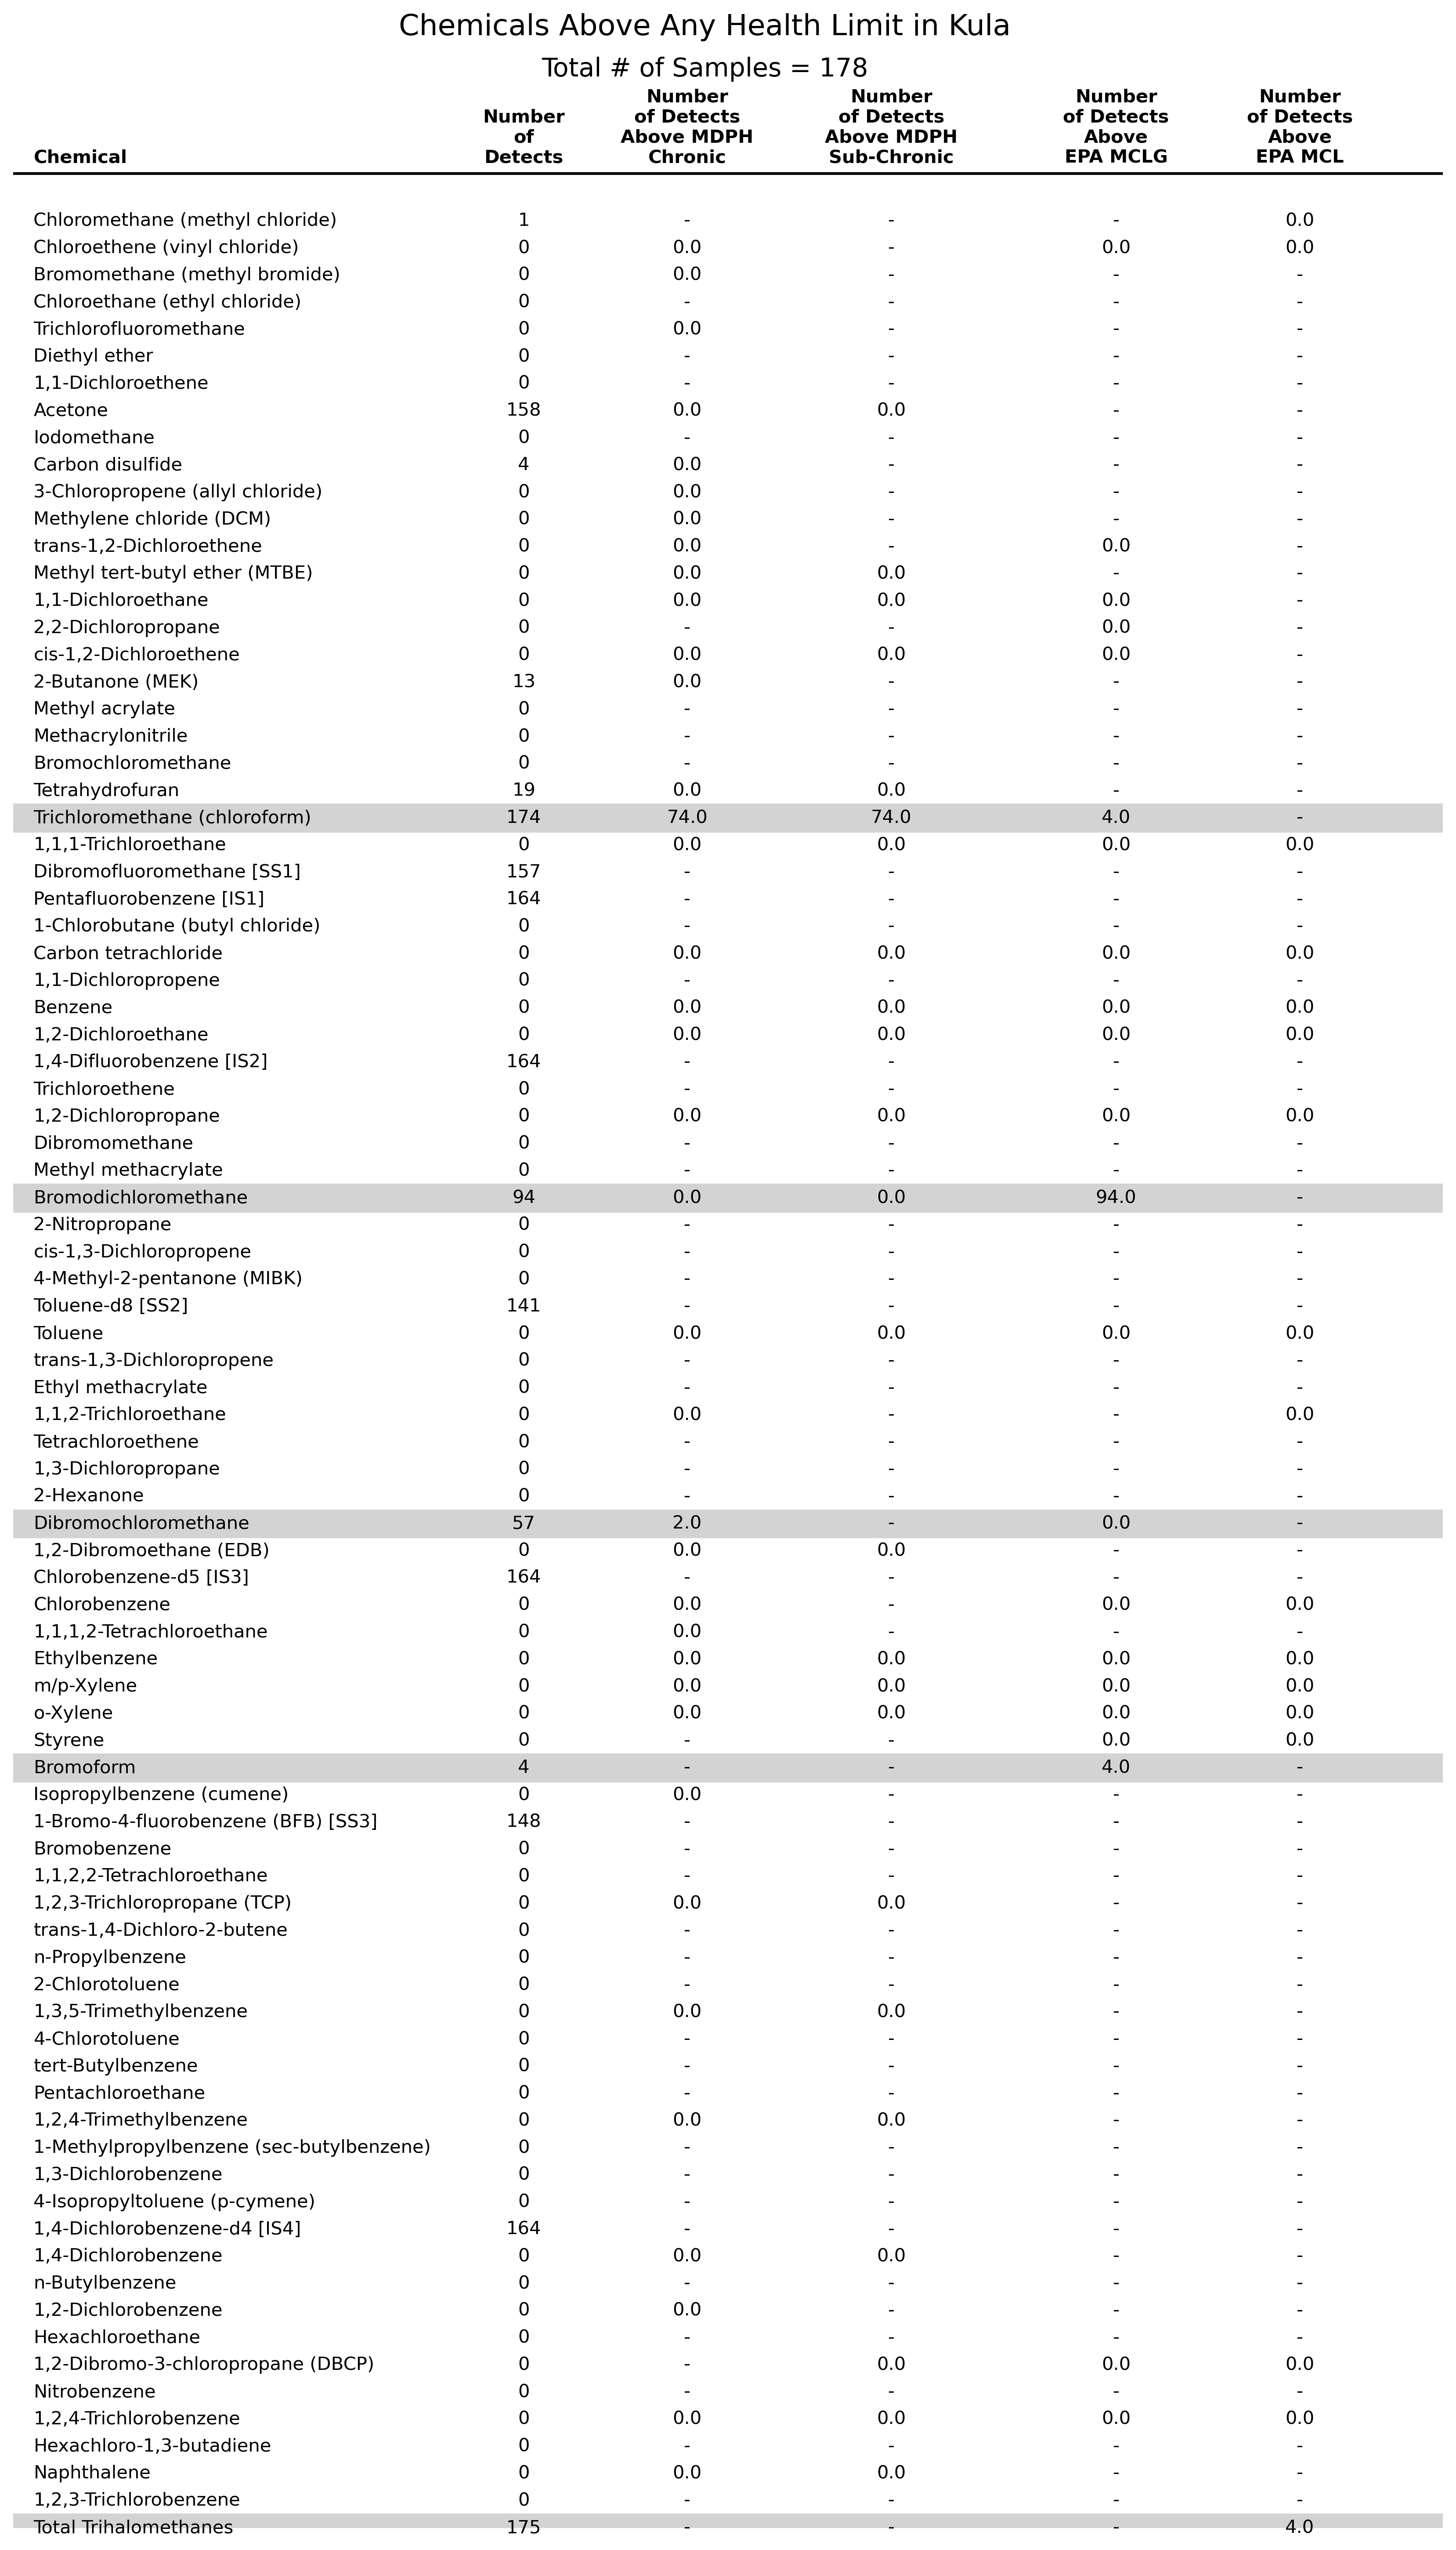

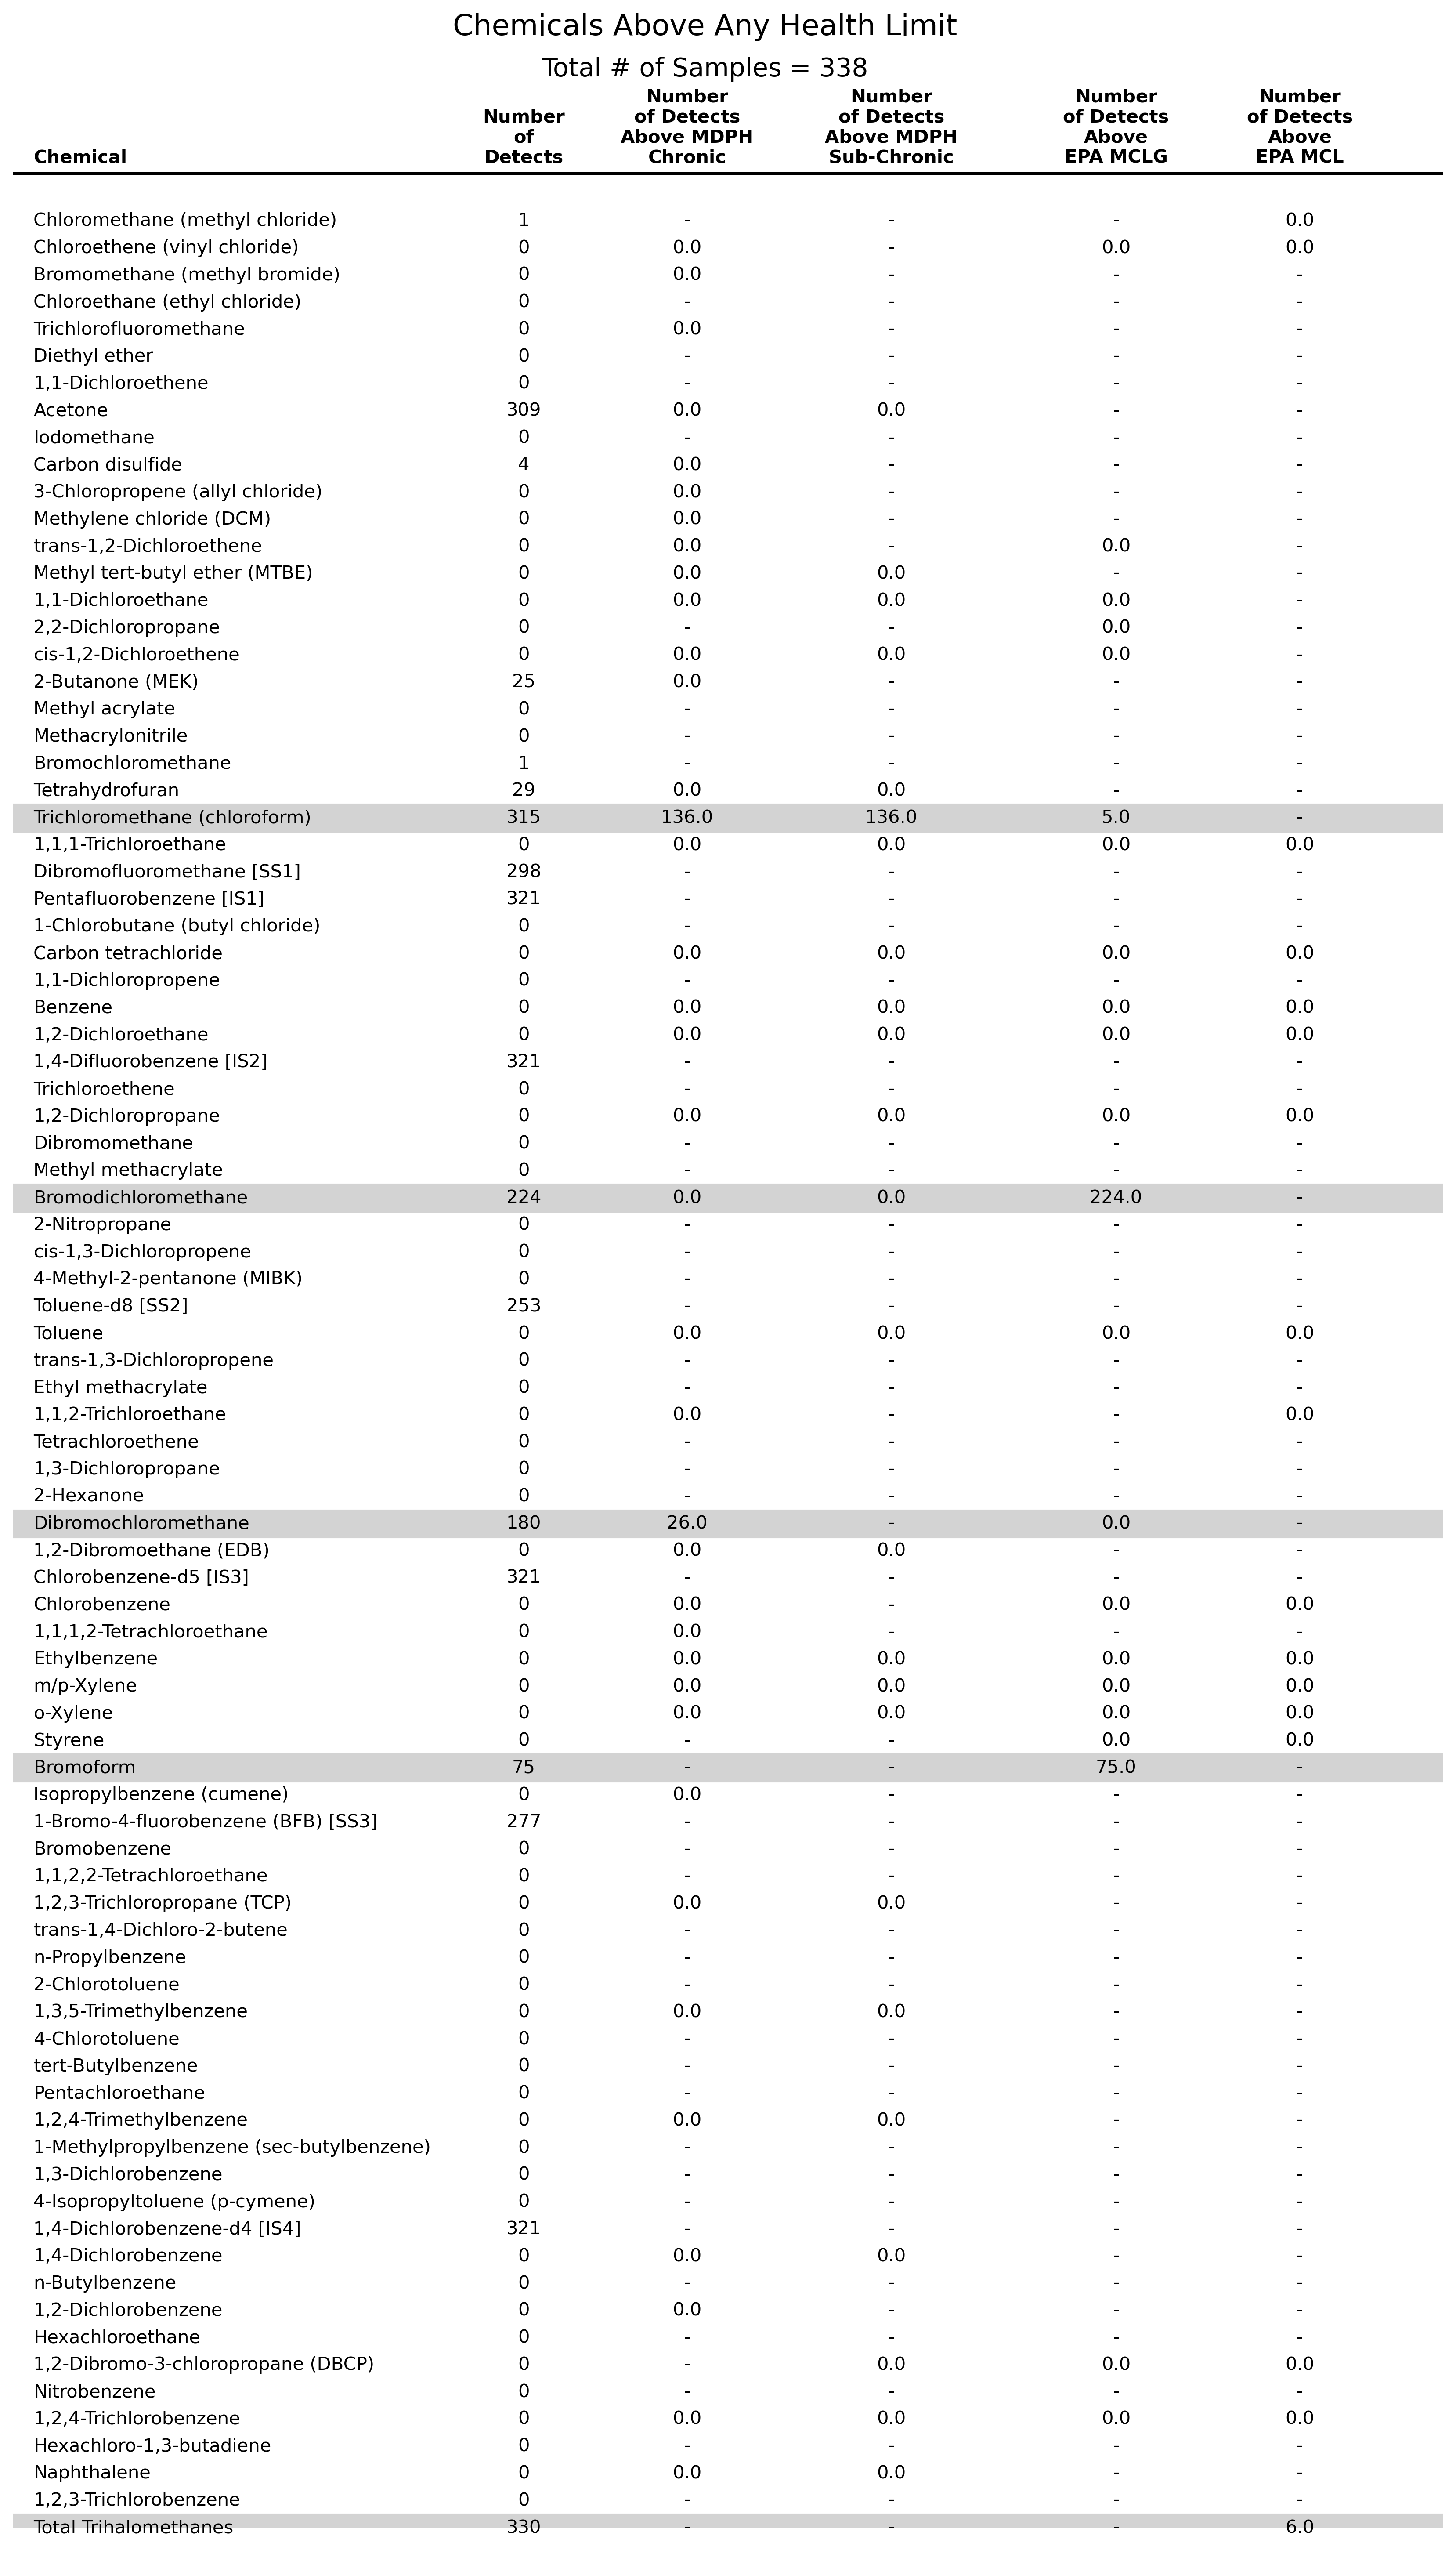

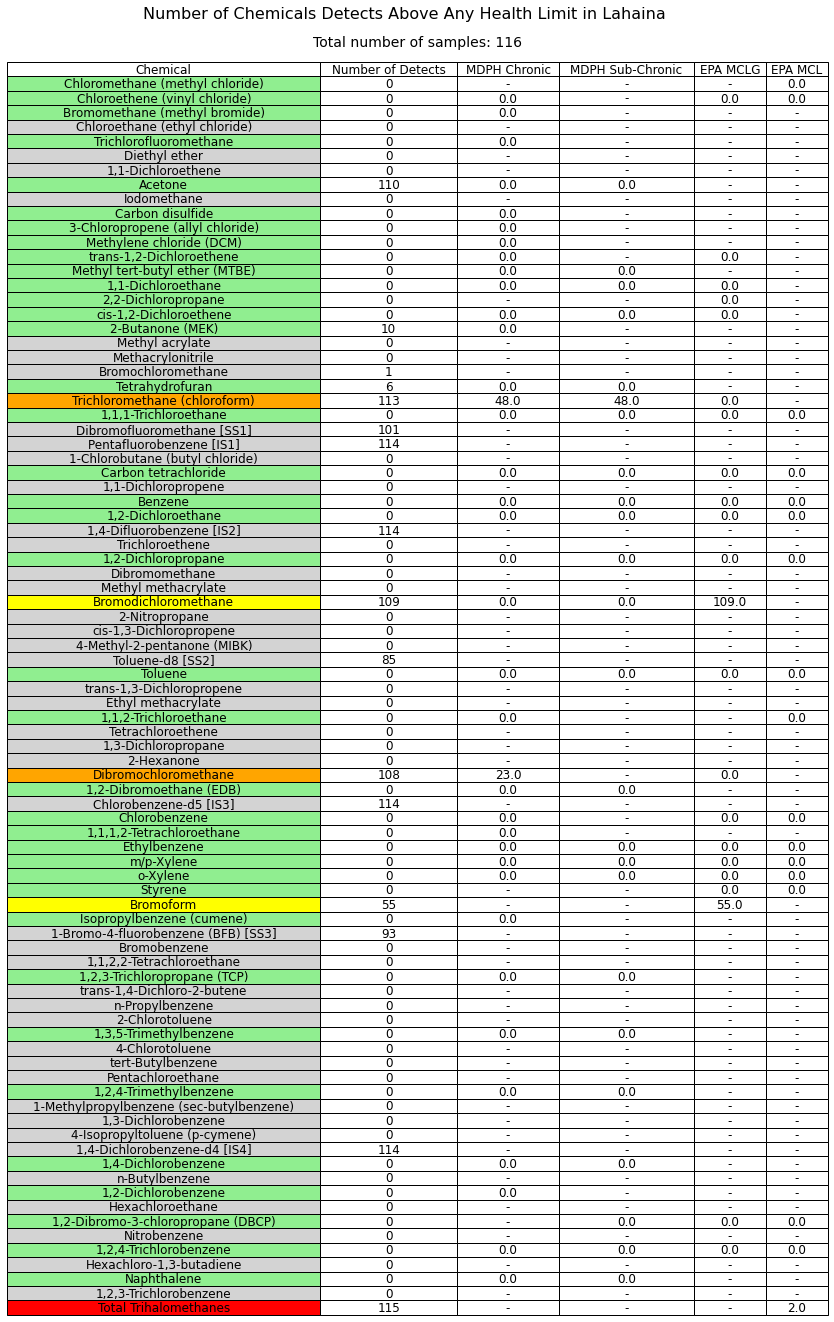

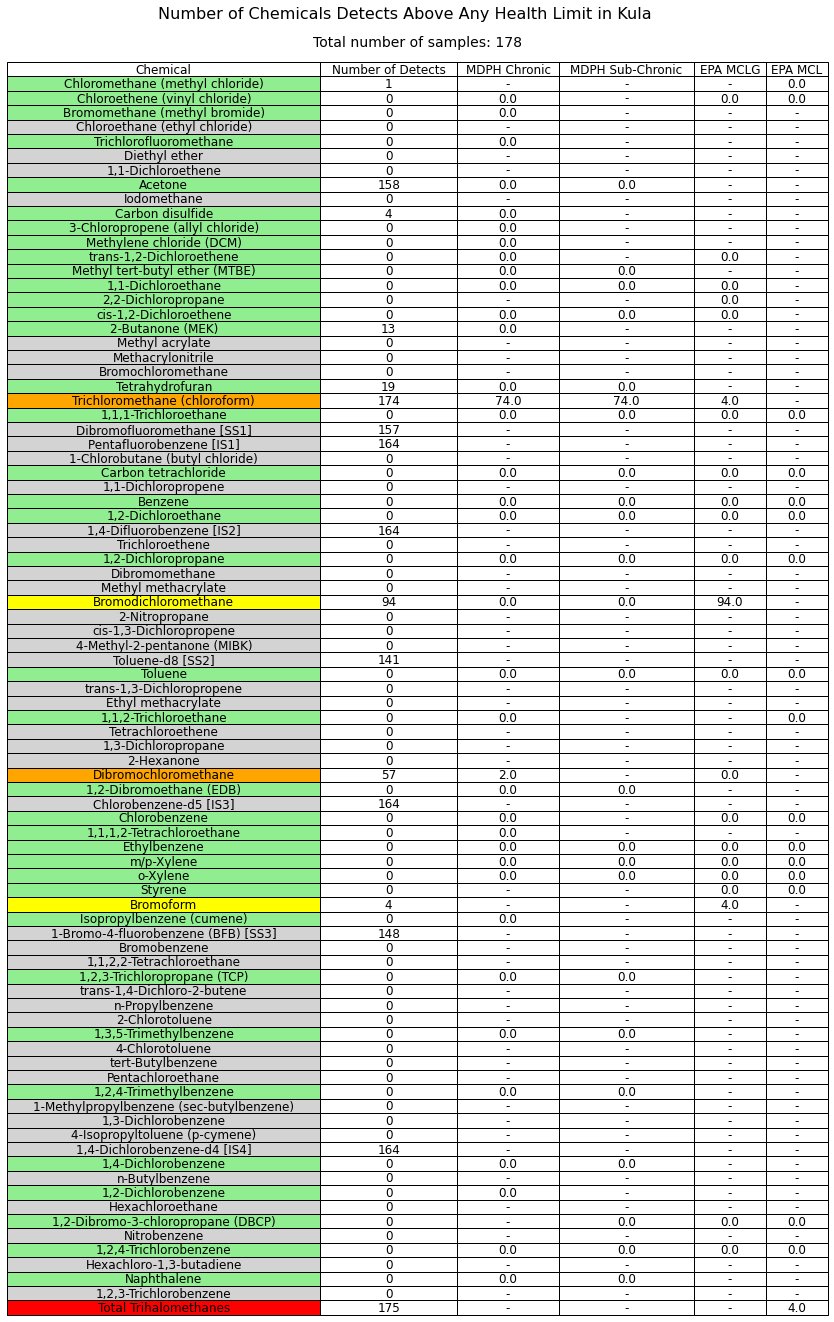

In [17]:

# ----------------------------------------------------------------------------------------------------#
# - Table for all health limit statuses (LAHAINA) -
# ----------------------------------------------------------------------------------------------------#

summary_data_combo = []

for chemical in chemical_columns:
    total_samples_combo = lahaina_df.shape[0]
    
    # Count detects that are neither NaN nor 0
    number_of_detects_combo = lahaina_df[chemical].apply(lambda x: not pd.isna(x) and x != 0).sum()

    # Get the health limits for the current chemical
    limit_row_combo = combined_limits_df[combined_limits_df['Chemical'] == chemical]
    if not limit_row_combo.empty:
        mdph_chronic_limit_combo = limit_row_combo['MDPH Chronic'].values[0]
        mdph_subchronic_limit_combo = limit_row_combo['MDPH Sub-Chronic'].values[0]
        epa_mcgl_limit_combo = limit_row_combo['EPA MCLG'].values[0]
        epa_mcl_limit_combo = limit_row_combo['EPA MCL'].values[0]
    else:
        mdph_chronic_limit_combo = np.nan
        mdph_subchronic_limit_combo = np.nan
        epa_mcgl_limit_combo = np.nan
        epa_mcl_limit_combo = np.nan

    if not np.isnan(mdph_chronic_limit_combo):
        number_of_detects_above_mdph_chronic_combo = (lahaina_df[chemical] > mdph_chronic_limit_combo).sum()
    else:
        number_of_detects_above_mdph_chronic_combo = np.nan

    if not np.isnan(mdph_subchronic_limit_combo):
        number_of_detects_above_mdph_subchronic_combo = (lahaina_df[chemical] > mdph_subchronic_limit_combo).sum()
    else:
        number_of_detects_above_mdph_subchronic_combo = np.nan

    if not np.isnan(epa_mcgl_limit_combo):
        number_of_detects_above_epa_mcgl_combo = (lahaina_df[chemical] > epa_mcgl_limit_combo).sum()
    else:
        number_of_detects_above_epa_mcgl_combo = np.nan

    if not np.isnan(epa_mcl_limit_combo):
        number_of_detects_above_epa_mcl_combo = (lahaina_df[chemical] > epa_mcl_limit_combo).sum()
    else:
        number_of_detects_above_epa_mcl_combo = np.nan

    summary_data_combo.append([chemical, total_samples_combo, number_of_detects_combo, number_of_detects_above_mdph_chronic_combo, number_of_detects_above_mdph_subchronic_combo, number_of_detects_above_epa_mcgl_combo, number_of_detects_above_epa_mcl_combo])

# Convert summary data to a DataFrame
summary_df_combo = pd.DataFrame(summary_data_combo, columns=['Chemical', 'Total number of samples', 'Number of Detects', 'Number of Detects Above MDPH Chronic', 'Number of Detects Above MDPH Sub-Chronic', 'Number of Detects Above EPA MCLG', 'Number of Detects Above EPA MCL'])
# Convert summary data to a DataFrame
summary_df_combo = summary_df_combo.fillna("-")
# Add colors
   
# Determine the rows that need highlighting
highlight_rows = summary_df_combo.apply(lambda row: any(cell != "-" and cell != 0 for cell in row[3:]), axis=1)

# Plotting the table using matplotlib
fig = plt.figure(figsize=(14, 24), dpi=300)  # Increase figure height significantly for more spacing
ax = plt.subplot()

ncols = 6
nrows = summary_df_combo.shape[0]

# Increase ylim to add more space between rows
ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows * 2 + 4)  # Adjust ylim to increase row spacing

positions = [0.1, 2.5, 3.3, 4.3, 5.4, 6.3]
columns = ['Chemical', 'Number of Detects', 'Number of Detects Above MDPH Chronic', 'Number of Detects Above MDPH Sub-Chronic', 'Number of Detects Above EPA MCLG', 'Number of Detects Above EPA MCL']

# Add table's main text
for i in range(nrows):
    y_position = (nrows - i - 1) * 2  # Adjust y position to increase spacing
    if highlight_rows.iloc[i]:
        ax.add_patch(plt.Rectangle((positions[0] - 0.1, y_position - 1), ncols + 1, 2, color='lightgray', zorder=0))
    for j, column in enumerate(columns):
        ha = 'left' if j == 0 else 'center'
        text_label = f'{summary_df_combo[column].iloc[i]}'
        ax.annotate(
            xy=(positions[j], y_position),
            text=text_label,
            ha=ha,
            va='center'
        )

# Add column names
column_names = ['Chemical', 'Number\nof\nDetects', 'Number\nof Detects\nAbove MDPH\nChronic', 'Number\nof Detects\nAbove MDPH\nSub-Chronic', 'Number\nof Detects\nAbove\nEPA MCLG', 'Number\nof Detects\nAbove\nEPA MCL']
for index, c in enumerate(column_names):
    ha = 'left' if index == 0 else 'center'
    ax.annotate(
        xy=(positions[index], nrows * 2 + 2),  # Adjusted the y position
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows * 2 + 1.5, nrows * 2 + 1.5], lw=1.5, color='black', marker='', zorder=4)  # Move the top line down below the column names
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-0.5, -0.5], lw=1.5, color='black', marker='', zorder=4)

ax.set_axis_off()
# Add title above the table
plt.suptitle('Chemicals Above Any Health Limit in Lahaina', fontsize=16, y=0.92)  # Adjusted the y position to move the title down
# Add the line for total number of samples
total_samples_combo = lahaina_df.shape[0]
plt.figtext(0.5, 0.90, f"Total # of Samples = {total_samples_combo}", ha='center', fontsize=14)  # Adjusted the y position to move the total samples text down

#plt.show()
# ----------------------------------------------------------------------------------------------------#
# - Table for all health limit statuses (KULA) -
# ----------------------------------------------------------------------------------------------------#

summary_data_combok = []

for chemical in chemical_columns:
    total_samples_combok = kula_df.shape[0]
    
    # Count detects that are neither NaN nor 0
    number_of_detects_combok = kula_df[chemical].apply(lambda x: not pd.isna(x) and x != 0).sum()

    # Get the health limits for the current chemical
    limit_row_combok = combined_limits_df[combined_limits_df['Chemical'] == chemical]
    if not limit_row_combok.empty:
        mdph_chronic_limit_combok = limit_row_combok['MDPH Chronic'].values[0]
        mdph_subchronic_limit_combok = limit_row_combok['MDPH Sub-Chronic'].values[0]
        epa_mcgl_limit_combok = limit_row_combok['EPA MCLG'].values[0]
        epa_mcl_limit_combok = limit_row_combok['EPA MCL'].values[0]
    else:
        mdph_chronic_limit_combok = np.nan
        mdph_subchronic_limit_combok = np.nan
        epa_mcgl_limit_combok = np.nan
        epa_mcl_limit_combok = np.nan

    if not np.isnan(mdph_chronic_limit_combok):
        number_of_detects_above_mdph_chronic_combok = (kula_df[chemical] > mdph_chronic_limit_combok).sum()
    else:
        number_of_detects_above_mdph_chronic_combok = np.nan

    if not np.isnan(mdph_subchronic_limit_combok):
        number_of_detects_above_mdph_subchronic_combok = (kula_df[chemical] > mdph_subchronic_limit_combok).sum()
    else:
        number_of_detects_above_mdph_subchronic_combok = np.nan

    if not np.isnan(epa_mcgl_limit_combok):
        number_of_detects_above_epa_mcgl_combok = (kula_df[chemical] > epa_mcgl_limit_combok).sum()
    else:
        number_of_detects_above_epa_mcgl_combok = np.nan

    if not np.isnan(epa_mcl_limit_combok):
        number_of_detects_above_epa_mcl_combok = (kula_df[chemical] > epa_mcl_limit_combok).sum()
    else:
        number_of_detects_above_epa_mcl_combok = np.nan

    summary_data_combok.append([chemical, total_samples_combok, number_of_detects_combok, number_of_detects_above_mdph_chronic_combok, number_of_detects_above_mdph_subchronic_combok, number_of_detects_above_epa_mcgl_combok, number_of_detects_above_epa_mcl_combok])

# Convert summary data to a DataFrame
summary_df_combok = pd.DataFrame(summary_data_combok, columns=['Chemical', 'Total number of samples', 'Number of Detects', 'Number of Detects Above MDPH Chronic', 'Number of Detects Above MDPH Sub-Chronic', 'Number of Detects Above EPA MCLG', 'Number of Detects Above EPA MCL'])
# Convert summary data to a DataFrame
summary_df_combok = summary_df_combok.fillna("-")

# Determine the rows that need highlighting
highlight_rows = summary_df_combok.apply(lambda row: any(cell != "-" and cell != 0 for cell in row[3:]), axis=1)

# Plotting the table using matplotlib
fig = plt.figure(figsize=(14, 24), dpi=300)  # Increase figure height significantly for more spacing
ax = plt.subplot()

ncols = 6
nrows = summary_df_combok.shape[0]

# Increase ylim to add more space between rows
ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows * 2 + 4)  # Adjust ylim to increase row spacing

positions = [0.1, 2.5, 3.3, 4.3, 5.4, 6.3]
columns = ['Chemical', 'Number of Detects', 'Number of Detects Above MDPH Chronic', 'Number of Detects Above MDPH Sub-Chronic', 'Number of Detects Above EPA MCLG', 'Number of Detects Above EPA MCL']

# Add table's main text
for i in range(nrows):
    y_position = (nrows - i - 1) * 2  # Adjust y position to increase spacing
    if highlight_rows.iloc[i]:
        ax.add_patch(plt.Rectangle((positions[0] - 0.1, y_position - 1), ncols + 1, 2, color='lightgray', zorder=0))
    for j, column in enumerate(columns):
        ha = 'left' if j == 0 else 'center'
        text_label = f'{summary_df_combok[column].iloc[i]}'
        ax.annotate(
            xy=(positions[j], y_position),
            text=text_label,
            ha=ha,
            va='center'
        )

# Add column names
column_names = ['Chemical', 'Number\nof\nDetects', 'Number\nof Detects\nAbove MDPH\nChronic', 'Number\nof Detects\nAbove MDPH\nSub-Chronic', 'Number\nof Detects\nAbove\nEPA MCLG', 'Number\nof Detects\nAbove\nEPA MCL']
for index, c in enumerate(column_names):
    ha = 'left' if index == 0 else 'center'
    ax.annotate(
        xy=(positions[index], nrows * 2 + 2),  # Adjusted the y position
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows * 2 + 1.5, nrows * 2 + 1.5], lw=1.5, color='black', marker='', zorder=4)  # Move the top line down below the column names
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-0.5, -0.5], lw=1.5, color='black', marker='', zorder=4)

ax.set_axis_off()
# Add title above the table
plt.suptitle('Chemicals Above Any Health Limit in Kula', fontsize=16, y=0.92)  # Adjusted the y position to move the title down
# Add the line for total number of samples
total_samples_combok = kula_df.shape[0]
plt.figtext(0.5, 0.90, f"Total # of Samples = {total_samples_combok}", ha='center', fontsize=14)  # Adjusted the y position to move the total samples text down

#plt.show()

# ----------------------------------------------------------------------------------------------------#
# - Ignoring locations: Summary Table -
# ----------------------------------------------------------------------------------------------------#

merged_df['Total Trihalomethanes'] = merged_df.apply(TTHM_Calculator, axis=1)

# Non-chemical columns
non_chemical_columns = ['Sample ID', 'SampleType', 'DateTime Taken', 'Public X', 'Public Y', 'City', 'Post Results']
chemical_columns = [col for col in merged_df.columns if col not in non_chemical_columns]
summary_data_all = []

merged_df.to_csv('tapwaterresults_clean.csv')

# Calculate the required columns for each chemical
for chemical in chemical_columns:
    total_samples_all = merged_df.shape[0]
    
    # Count detects that are neither NaN nor 0
    number_of_detects_all = merged_df[chemical].apply(lambda x: not pd.isna(x) and x != 0).sum()

    # Get the health limits for the current chemical
    limit_row_all = combined_limits_df[combined_limits_df['Chemical'] == chemical]
    if not limit_row_all.empty:
        mdph_chronic_limit_all = limit_row_all['MDPH Chronic'].values[0]
        mdph_subchronic_limit_all = limit_row_all['MDPH Sub-Chronic'].values[0]
        epa_mcgl_limit_all = limit_row_all['EPA MCLG'].values[0]
        epa_mcl_limit_all = limit_row_all['EPA MCL'].values[0]
    else:
        mdph_chronic_limit_all = np.nan
        mdph_subchronic_limit_all = np.nan
        epa_mcgl_limit_all = np.nan
        epa_mcl_limit_all = np.nan

    if not np.isnan(mdph_chronic_limit_all):
        number_of_detects_above_mdph_chronic_all = (merged_df[chemical] > mdph_chronic_limit_all).sum()
    else:
        number_of_detects_above_mdph_chronic_all = np.nan

    if not np.isnan(mdph_subchronic_limit_all):
        number_of_detects_above_mdph_subchronic_all = (merged_df[chemical] > mdph_subchronic_limit_all).sum()
    else:
        number_of_detects_above_mdph_subchronic_all = np.nan

    if not np.isnan(epa_mcgl_limit_all):
        number_of_detects_above_epa_mcgl_all = (merged_df[chemical] > epa_mcgl_limit_all).sum()
    else:
        number_of_detects_above_epa_mcgl_all = np.nan

    if not np.isnan(epa_mcl_limit_all):
        number_of_detects_above_epa_mcl_all = (merged_df[chemical] > epa_mcl_limit_all).sum()
    else:
        number_of_detects_above_epa_mcl_all = np.nan

    summary_data_all.append([chemical, total_samples_all, number_of_detects_all, number_of_detects_above_mdph_chronic_all, number_of_detects_above_mdph_subchronic_all, number_of_detects_above_epa_mcgl_all, number_of_detects_above_epa_mcl_all])

# Convert summary data to a DataFrame
summary_df_all = pd.DataFrame(summary_data_all, columns=['Chemical', 'Total number of samples', 'Number of Detects', 'Number of Detects Above MDPH Chronic', 'Number of Detects Above MDPH Sub-Chronic', 'Number of Detects Above EPA MCLG', 'Number of Detects Above EPA MCL'])
# Convert summary data to a DataFrame
summary_df_all = summary_df_all.fillna("-")

# Determine the rows that need highlighting
highlight_rows = summary_df_all.apply(lambda row: any(cell != "-" and cell != 0 for cell in row[3:]), axis=1)

# Plotting the table using matplotlib
fig = plt.figure(figsize=(14, 24), dpi=300)  # Increase figure height significantly for more spacing
ax = plt.subplot()

ncols = 6
nrows = summary_df_all.shape[0]

# Increase ylim to add more space between rows
ax.set_xlim(0, ncols + 1)
ax.set_ylim(0, nrows * 2 + 4)  # Adjust ylim to increase row spacing

positions = [0.1, 2.5, 3.3, 4.3, 5.4, 6.3]
columns = ['Chemical', 'Number of Detects', 'Number of Detects Above MDPH Chronic', 'Number of Detects Above MDPH Sub-Chronic', 'Number of Detects Above EPA MCLG', 'Number of Detects Above EPA MCL']

# Add table's main text
for i in range(nrows):
    y_position = (nrows - i - 1) * 2  # Adjust y position to increase spacing
    if highlight_rows.iloc[i]:
        ax.add_patch(plt.Rectangle((positions[0] - 0.1, y_position - 1), ncols + 1, 2, color='lightgray', zorder=0))
    for j, column in enumerate(columns):
        ha = 'left' if j == 0 else 'center'
        text_label = f'{summary_df_all[column].iloc[i]}'
        ax.annotate(
            xy=(positions[j], y_position),
            text=text_label,
            ha=ha,
            va='center'
        )

# Add column names
column_names = ['Chemical', 'Number\nof\nDetects', 'Number\nof Detects\nAbove MDPH\nChronic', 'Number\nof Detects\nAbove MDPH\nSub-Chronic', 'Number\nof Detects\nAbove\nEPA MCLG', 'Number\nof Detects\nAbove\nEPA MCL']
for index, c in enumerate(column_names):
    ha = 'left' if index == 0 else 'center'
    ax.annotate(
        xy=(positions[index], nrows * 2 + 2),  # Adjusted the y position
        text=column_names[index],
        ha=ha,
        va='bottom',
        weight='bold'
    )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows * 2 + 1.5, nrows * 2 + 1.5], lw=1.5, color='black', marker='', zorder=4)  # Move the top line down below the column names
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-0.5, -0.5], lw=1.5, color='black', marker='', zorder=4)

ax.set_axis_off()

# Add title above the table
plt.suptitle('Chemicals Above Any Health Limit', fontsize=16, y=0.92)  # Adjusted the y position to move the title down
# Add the line for total number of samples
total_samples = merged_df.shape[0]
plt.figtext(0.5, 0.90, f"Total # of Samples = {total_samples}", ha='center', fontsize=14)  # Adjusted the y position to move the total samples text down

#plt.show()



# ----------------------------------------------------------------------------------------------------#
# - Table to match Chris's: to be posted -
# ----------------------------------------------------------------------------------------------------#

#L A H A I N A
summary_data_combo = []

for chemical in chemical_columns:
    total_samples_combo = lahaina_df.shape[0]

    # Count detects that are neither NaN nor 0
    number_of_detects_combo = lahaina_df[chemical].apply(lambda x: not pd.isna(x) and x != 0).sum()

    # Get the health limits for the current chemical
    limit_row_combo = combined_limits_df[combined_limits_df['Chemical'] == chemical]
    if not limit_row_combo.empty:
        mdph_chronic_limit_combo = limit_row_combo['MDPH Chronic'].values[0]
        mdph_subchronic_limit_combo = limit_row_combo['MDPH Sub-Chronic'].values[0]
        epa_mcgl_limit_combo = limit_row_combo['EPA MCLG'].values[0]
        epa_mcl_limit_combo = limit_row_combo['EPA MCL'].values[0]
    else:
        mdph_chronic_limit_combo = np.nan
        mdph_subchronic_limit_combo = np.nan
        epa_mcgl_limit_combo = np.nan
        epa_mcl_limit_combo = np.nan

    if not np.isnan(mdph_chronic_limit_combo):
        number_of_detects_above_mdph_chronic_combo = (lahaina_df[chemical] > mdph_chronic_limit_combo).sum()
    else:
        number_of_detects_above_mdph_chronic_combo = np.nan

    if not np.isnan(mdph_subchronic_limit_combo):
        number_of_detects_above_mdph_subchronic_combo = (lahaina_df[chemical] > mdph_subchronic_limit_combo).sum()
    else:
        number_of_detects_above_mdph_subchronic_combo = np.nan

    if not np.isnan(epa_mcgl_limit_combo):
        number_of_detects_above_epa_mcgl_combo = (lahaina_df[chemical] > epa_mcgl_limit_combo).sum()
    else:
        number_of_detects_above_epa_mcgl_combo = np.nan

    if not np.isnan(epa_mcl_limit_combo):
        number_of_detects_above_epa_mcl_combo = (lahaina_df[chemical] > epa_mcl_limit_combo).sum()
    else:
        number_of_detects_above_epa_mcl_combo = np.nan

    summary_data_combo.append([chemical, number_of_detects_combo, number_of_detects_above_mdph_chronic_combo, number_of_detects_above_mdph_subchronic_combo, number_of_detects_above_epa_mcgl_combo, number_of_detects_above_epa_mcl_combo])

# Convert summary data to a DataFrame
summary_df_combo = pd.DataFrame(summary_data_combo, columns=['Chemical', 'Number of Detects', 'Detects Above MDPH Chronic', 'Detects Above MDPH Sub-Chronic', 'Detects Above EPA MCLG', 'Detects Above EPA MCL'])

# Ensure numeric columns are of numeric type, except for cells with "-"
numeric_columns = ['Number of Detects', 'Detects Above MDPH Chronic', 'Detects Above MDPH Sub-Chronic', 'Detects Above EPA MCLG', 'Detects Above EPA MCL']
for col in numeric_columns:
    summary_df_combo[col] = pd.to_numeric(summary_df_combo[col], errors='coerce')

# Fill NaNs with "-"
summary_df_combo = summary_df_combo.fillna("-")

# Function to determine the color of the chemical name cell based on the conditions
def get_chemical_color(row):
    if all(row[col] == "-" for col in numeric_columns[1:]):
        return 'lightgrey'
    elif any(row[col] != "-" and row[col] > 0 for col in numeric_columns[1:]):
        if row['Detects Above EPA MCL'] != "-" and row['Detects Above EPA MCL'] > 0:
            return 'red'
        elif row['Detects Above MDPH Sub-Chronic'] != "-" and row['Detects Above MDPH Sub-Chronic'] > 0:
            return 'orange'
        elif row['Detects Above MDPH Chronic'] != "-" and row['Detects Above MDPH Chronic'] > 0:
            return 'orange'
        elif row['Detects Above EPA MCLG'] != "-" and row['Detects Above EPA MCLG'] > 0:
            return 'yellow'
    elif all(row[col] == 0 or row[col] == "-" for col in numeric_columns[1:]):
        return 'lightgreen'
    return 'white'

# Plotting the table using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust figure size as needed

ax.set_axis_off()

# Create a table
table = ax.table(
    cellText=summary_df_combo.values,
    colLabels=[
        'Chemical', 
        'Number of Detects', 
        'MDPH Chronic', 
        'MDPH Sub-Chronic', 
        'EPA MCLG', 
        'EPA MCL'
    ],
    cellLoc='center',
    loc='center'
)

# Set the width of the "Chemical" column to be wider
table.auto_set_column_width([0, 1, 2, 3, 4, 5])
col_widths = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1]  # Adjust the first value to make the "Chemical" column wider

for i, width in enumerate(col_widths):
    table.auto_set_column_width(i)
    for j in range(len(summary_df_combo) + 1):
        table[(j, i)].set_width(width)

# Apply color coding to the chemical name column only
for i in range(len(summary_df_combo)):
    color = get_chemical_color(summary_df_combo.iloc[i])
    cell = table[(i + 1, 0)]  # Only color the "Chemical" column
    cell.set_facecolor(color)

# Adjust the appearance
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Scale the table as needed

# Add title and subtitle above the table
plt.suptitle('Number of Chemicals Detects Above Any Health Limit in Lahaina', fontsize=16, y=1.45)  # Move title higher up
plt.title(f'Total number of samples: {total_samples_combo}', fontsize=14, y=1.67)  # Add subtitle below the title
plt.savefig('summary_lahaina_plot.png')

# Show plot
plt.show()



#K U L A
summary_data_kula = []

for chemical in chemical_columns:
    total_samples_kula = kula_df.shape[0]

    # Count detects that are neither NaN nor 0
    number_of_detects_kula = kula_df[chemical].apply(lambda x: not pd.isna(x) and x != 0).sum()

    # Get the health limits for the current chemical
    limit_row_kula = combined_limits_df[combined_limits_df['Chemical'] == chemical]
    if not limit_row_kula.empty:
        mdph_chronic_limit_kula = limit_row_kula['MDPH Chronic'].values[0]
        mdph_subchronic_limit_kula = limit_row_kula['MDPH Sub-Chronic'].values[0]
        epa_mcgl_limit_kula = limit_row_kula['EPA MCLG'].values[0]
        epa_mcl_limit_kula = limit_row_kula['EPA MCL'].values[0]
    else:
        mdph_chronic_limit_kula = np.nan
        mdph_subchronic_limit_kula = np.nan
        epa_mcgl_limit_kula = np.nan
        epa_mcl_limit_kula = np.nan

    if not np.isnan(mdph_chronic_limit_kula):
        number_of_detects_above_mdph_chronic_kula = (kula_df[chemical] > mdph_chronic_limit_kula).sum()
    else:
        number_of_detects_above_mdph_chronic_kula = np.nan

    if not np.isnan(mdph_subchronic_limit_kula):
        number_of_detects_above_mdph_subchronic_kula = (kula_df[chemical] > mdph_subchronic_limit_kula).sum()
    else:
        number_of_detects_above_mdph_subchronic_kula = np.nan

    if not np.isnan(epa_mcgl_limit_kula):
        number_of_detects_above_epa_mcgl_kula = (kula_df[chemical] > epa_mcgl_limit_kula).sum()
    else:
        number_of_detects_above_epa_mcgl_kula = np.nan

    if not np.isnan(epa_mcl_limit_kula):
        number_of_detects_above_epa_mcl_kula = (kula_df[chemical] > epa_mcl_limit_kula).sum()
    else:
        number_of_detects_above_epa_mcl_kula = np.nan

    summary_data_kula.append([chemical, number_of_detects_kula, number_of_detects_above_mdph_chronic_kula, number_of_detects_above_mdph_subchronic_kula, number_of_detects_above_epa_mcgl_kula, number_of_detects_above_epa_mcl_kula])

# Convert summary data to a DataFrame
summary_df_kula = pd.DataFrame(summary_data_kula, columns=['Chemical', 'Number of Detects', 'Detects Above MDPH Chronic', 'Detects Above MDPH Sub-Chronic', 'Detects Above EPA MCLG', 'Detects Above EPA MCL'])

# Ensure numeric columns are of numeric type, except for cells with "-"
numeric_columns = ['Number of Detects', 'Detects Above MDPH Chronic', 'Detects Above MDPH Sub-Chronic', 'Detects Above EPA MCLG', 'Detects Above EPA MCL']
for col in numeric_columns:
    summary_df_kula[col] = pd.to_numeric(summary_df_kula[col], errors='coerce')

# Fill NaNs with "-"
summary_df_kula = summary_df_kula.fillna("-")

# Function to determine the color of the chemical name cell based on the conditions
def get_chemical_color(row):
    if all(row[col] == "-" for col in numeric_columns[1:]):
        return 'lightgrey'
    elif any(row[col] != "-" and row[col] > 0 for col in numeric_columns[1:]):
        if row['Detects Above EPA MCL'] != "-" and row['Detects Above EPA MCL'] > 0:
            return 'red'
        elif row['Detects Above MDPH Sub-Chronic'] != "-" and row['Detects Above MDPH Sub-Chronic'] > 0:
            return 'orange'
        elif row['Detects Above MDPH Chronic'] != "-" and row['Detects Above MDPH Chronic'] > 0:
            return 'orange'
        elif row['Detects Above EPA MCLG'] != "-" and row['Detects Above EPA MCLG'] > 0:
            return 'yellow'
    elif all(row[col] == 0 or row[col] == "-" for col in numeric_columns[1:]):
        return 'lightgreen'
    return 'white'

# Plotting the table using matplotlib
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust figure size as needed

ax.set_axis_off()

# Create a table
table = ax.table(
    cellText=summary_df_kula.values,
    colLabels=[
        'Chemical', 
        'Number of Detects', 
        'MDPH Chronic', 
        'MDPH Sub-Chronic', 
        'EPA MCLG', 
        'EPA MCL'
    ],
    cellLoc='center',
    loc='center'
)

# Set the width of the "Chemical" column to be wider
table.auto_set_column_width([0, 1, 2, 3, 4, 5])
col_widths = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1]  # Adjust the first value to make the "Chemical" column wider

for i, width in enumerate(col_widths):
    table.auto_set_column_width(i)
    for j in range(len(summary_df_kula) + 1):
        table[(j, i)].set_width(width)

# Apply color coding to the chemical name column only
for i in range(len(summary_df_kula)):
    color = get_chemical_color(summary_df_kula.iloc[i])
    cell = table[(i + 1, 0)]  # Only color the "Chemical" column
    cell.set_facecolor(color)

# Adjust the appearance
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Scale the table as needed

# Add title and subtitle above the table
plt.suptitle('Number of Chemicals Detects Above Any Health Limit in Kula', fontsize=16, y=1.45)  # Move title higher up
plt.title(f'Total number of samples: {total_samples_kula}', fontsize=14, y=1.67)  # Add subtitle below the title
plt.savefig('summary_kula_plot.png')
# Show plot
plt.show()



In [18]:
summary_df_combo

Chemical  Number of Detects  \
0   Chloromethane (methyl chloride)                  0   
1     Chloroethene (vinyl chloride)                  0   
2     Bromomethane (methyl bromide)                  0   
3     Chloroethane (ethyl chloride)                  0   
4            Trichlorofluoromethane                  0   
..                              ...                ...   
81           1,2,4-Trichlorobenzene                  0   
82         Hexachloro-1,3-butadiene                  0   
83                      Naphthalene                  0   
84           1,2,3-Trichlorobenzene                  0   
85            Total Trihalomethanes                115   

   Detects Above MDPH Chronic Detects Above MDPH Sub-Chronic  \
0                           -                              -   
1                         0.0                              -   
2                         0.0                              -   
3                           -                              -   
4                         0.0                              -   
..                        ...                            ...   
81                        0.0                            0.0   
82                          -                              -   
83                        0.0                            0.0   
84                          -                              -   
85                          -                              -   

   Detects Above EPA MCLG Detects Above EPA MCL  
0                       -                   0.0  
1                     0.0                   0.0  
2                       -                     -  
3                       -                     -  
4                       -                     -  
..                    ...                   ...  
81                    0.0                   0.0  
82                      -                     -  
83                      -                     -  
84                      -                     -  
85                      -                   2.0  

[86 rows x 6 columns]

In [23]:
merged_df.to_csv("MergeCheck.csv")

In [25]:
# Messing around 





# ----------------------------------------------------------------------------------------------------#
# - Bring in public data -
# ----------------------------------------------------------------------------------------------------#

# Try and access file path of public data 
url = 'https://github.com/cshuler/VOC_Processing_Maui/blob/main/MASTER_Maui_VOC_Sheet_PUBLIC.csv?raw=true'
df = pd.read_csv(url,index_col=0)
print(df.head(5))
# Only have tapwater samples 
tap_water_variations = ['Tap Water', 'tap', 'Tap', 'tap water', 'Tap Water Filtered']
#Filter the dataframe
tapwaterdf = df[df['SampleType'].isin(tap_water_variations)]
print(tapwaterdf)

# ----------------------------------------------------------------------------------------------------#
# - Bring in clean VOC data -
# ----------------------------------------------------------------------------------------------------#

# Function to get the list of CSV files from the GitHub repository page
def get_csv_files_from_repo(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        files = response.json()
        csv_files = [file['download_url'] for file in files if file['name'].endswith('.csv')]
        return csv_files
    else:
        raise ValueError(f"Failed to fetch repository contents: {response.status_code}")

# URL of the GitHub repository API
api_url = "https://api.github.com/repos/cshuler/VOC_Processing_Maui/contents/Clean_Data"

# Get the list of CSV files
csv_files = get_csv_files_from_repo(api_url)

# Check if the list of CSV files is populated
if not csv_files:
    raise ValueError("No CSV files found in the repository")

# Function to read a CSV file from a URL into a DataFrame
def read_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    return pd.read_csv(StringIO(response.text))

# Read all CSV files into a list of DataFrames and set 'Peak' as the index
dataframes = []
for url in csv_files:
    try:
        df = read_csv_from_url(url)
        df.set_index('Peak', inplace=True)
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {url}: {e}")
# Ensure there are DataFrames to concatenate
if not dataframes:
    raise ValueError("No DataFrames were read successfully")

    
    
    # ----------------------------------------------------------------------------------------------------#
# - Calc detects -
# ----------------------------------------------------------------------------------------------------#

def compare_samples_to_limit(df):
    # Identify the reporting limit column
    limit_col = [col for col in df.columns if 'Reporting_Limit' in col][0]
    
    # Identify the sample columns (all columns except the reporting limit)
    sample_cols = [col for col in df.columns if col != limit_col]
    
    # Compare and set sample values
    for sample_col in sample_cols:
        df[sample_col] = df.apply(lambda row: 0 if row[sample_col] < row[limit_col] else row[sample_col], axis=1)
    
    return df

# Process each DataFrame
for i, df in enumerate(dataframes):
    df.replace(['n.a.', 'n.a./n.r.'], np.nan, inplace=True)
    # Convert all values to numeric (float), coercing errors to NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    dataframes[i] = compare_samples_to_limit(df) 
    
# Note that # ALL VALUES LESS THAN REPORTING LIMIT IS SET TO 0#


# ----------------------------------------------------------------------------------------------------#
# -DATFRAME comboination cleanup -
# ----------------------------------------------------------------------------------------------------#

filtered_combined_df = combined_df.loc[specified_chemicals]

# Transpose the filtered dataframe
transposed_df = filtered_combined_df.T

# Reset the index to turn columns into rows
transposed_df.reset_index(inplace=True)
transposed_df.rename(columns={'index': 'Sample ID'}, inplace=True)


merged_df = pd.merge(tapwaterdf, transposed_df, on='Sample ID', how='inner')

def is_in_bounding_box(lat, lon, bounding_box):
    lat_min, lon_min, lat_max, lon_max = bounding_box
    return lat_min <= lat <= lat_max and lon_min <= lon <= lon_max

def get_city(latitude, longitude):
    lahaina_bounding_box = (20.8485, -156.6967, 20.907, -156.6429)
    kula_bounding_box = (20.685866, -156.402346, 20.812532, -156.277054)

    if is_in_bounding_box(latitude, longitude, lahaina_bounding_box):
        return "Lahaina"
    elif is_in_bounding_box(latitude, longitude, kula_bounding_box):
        return "Kula"
    else:
        return "Outside of Boxes"

# Apply the get_city function to each row in the DataFrame
merged_df['City'] = merged_df.apply(lambda row: get_city(row['Public Y'], row['Public X']), axis=1)



merged_df.to_csv("MergeCheck2.csv")

     Sample ID          SampleType   DateTime Taken Post Results    Public X  \
0  08-16-CKS-1           DI water    8/16/2023 8:15            N -156.475427   
1  08-16-CKS-2           Tap Water   8/16/2023 9:30          NaN -156.314808   
2  08-16-CKS-3           Tap Water  8/16/2023 10:52          NaN -156.307080   
3  08-16-CKS-4           Tap Water  8/16/2023 11:11          NaN -156.310102   
4  08-16-CKS-5  Tap Water Filtered  8/16/2023 11:30          NaN -156.307506   

    Public Y  
0  20.888238  
1  20.775476  
2  20.776551  
3  20.775450  
4  20.779323  
        Sample ID          SampleType   DateTime Taken Post Results  \
1     08-16-CKS-2           Tap Water   8/16/2023 9:30          NaN   
2     08-16-CKS-3           Tap Water  8/16/2023 10:52          NaN   
3     08-16-CKS-4           Tap Water  8/16/2023 11:11          NaN   
4     08-16-CKS-5  Tap Water Filtered  8/16/2023 11:30          NaN   
5     08-16-CKS-6           Tap Water  8/16/2023 12:00          NaN   
.. 